In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle

import awkward as ak
import mplhep as hep
import argparse     # to get arguments from command line executing file.py
import os # read directories etc.
from scipy.signal import find_peaks, gaussian
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import pylandau
import re
import copy

verbose = False
debug = False

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pd.set_option('display.max_columns', None)

!ls ../Data_TestBeam/2023_May/

'CERN Testbeam May 2023 - RunLog.csv'   configs   plots   S1   S2


In [3]:
def tree_to_df(tree, branches):
    """
    Converts tree object from a file.root into pandas DataFrame unpacking branches with multiple channels
    into 'Branch_0', 'Branch_1' etc.
    """
#     tree = uproot.open("../Data_TestBeam/2023_May/S1/tree_May2023_S1_301.root:tree")
    df_ak = tree.arrays(branches, library='ak') # changed library from pd (pandas) to ak (awkward)
    df = pd.DataFrame()

    for name in branches: # converts all entries into Entry_0, Entry_1 etc.
        try:  # if the shape of the branch 'name' is more than 1
            for idx in range(np.shape(df_ak[name])[1]):
                new_columns = pd.DataFrame(df_ak[name][:,idx])
                new_columns.columns = [f'{name}_{idx}']   # rename it to Entry_idx
                df = pd.concat([df, new_columns], axis=1)
        except:  
            new_columns = pd.DataFrame(df_ak[name])
            new_columns.columns = [f'{name}']
            df = pd.concat([df,new_columns], axis=1)
    return df


def plot_histogram(data, poisson_err=False, bins='auto', **kwrd_arg):
    """
    Plot a simple (list of) histogram with optionally the poissonian error.
    Returns 'figure' and 'axis' so that more hist/plots can be added
    """
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    ax.grid('--')
    hist_points, bins_points, _ = ax.hist(data, bins=bins, histtype='step', **kwrd_arg)
    if (poisson_err):      # adding the poissonian error (sqrt(hist_point)
        bins_centers = (bins_points[1:]+bins_points[:-1])/2
        if (np.shape(np.shape(data))[0]>1): # a bit convoluted but checks the dimensions of the data
            for single_hist in hist_points:     # in case data is a list of data
                ax.errorbar(bins_centers, single_hist, yerr=single_hist**0.5, elinewidth=2, marker='.', linewidth=0, alpha=0.7)
        else:
            ax.errorbar(bins_centers, hist_points, yerr=hist_points**0.5, elinewidth=2, marker='.', linewidth=0, alpha=0.7)
    return fig, ax


def add_histogram(ax, data, bins='auto',  **kwrd_arg):
    ax.hist(data, bins=bins, histtype='step',  **kwrd_arg)


def find_min_btw_peaks(data, bins, prominence, distance, plot=True):
    """Finds the minimun between two peaks, returns x position of min"""
    hist, bins_hist, _ = plt.hist(data, bins=bins, histtype='step')
    bins_centers = (bins_hist[1:]+bins_hist[:-1])/2
    peaks_idx, _ = find_peaks(hist, prominence=prominence, distance=distance)
    plt.plot(bins_centers[peaks_idx], hist[peaks_idx], 'x', markersize=10, color='k', label='Peaks')
    try:
        global_min, _ = find_peaks(-hist[peaks_idx[0]:peaks_idx[-1]], prominence=prominence, distance=distance)
    except:
        print("Didn't find 2 peaks")
        return
    try: x_min = bins_centers[global_min+peaks_idx[0]][0]
    except:
        print("no x_min found")
        return
    plt.plot(x_min, hist[global_min+peaks_idx[0]][0], 'o', markersize=10, color='b', label='Mimimum: %.1f'%x_min)
    if not plot: plt.close()
#     y_min = hist[global_min+peaks_idx[0]][0]
    return  x_min#, y_min


def find_min_kde(data, x_axis):
    kde = gaussian_kde(dataset=data.to_numpy()).evaluate(x_axis)
    peaks = find_peaks(kde)[0]
    try: minimun = find_peaks(-kde[peaks[0]:peaks[1]])
    except: 
        print("Didn't find 2 peaks")
        return
    return x_axis[minimun[0]+peaks[0]]


def find_edges(data, bins='auto', plot=False):
    """
    Finds the 'edges' of the sensor using the gradient of the hits distribution
    returns: left_edge, right_edge
    """
    hist, bins_points, _ = plt.hist(data, bins=bins, histtype='step')
    bins_centers = (bins_points[1:]+bins_points[:-1])/2
    left_edge = bins_centers[np.argmax(np.gradient(hist))]
    right_edge = bins_centers[np.argmin(np.gradient(hist))]
    if not plot: plt.close()
    return left_edge, right_edge


def my_and(x,y):
    """I need a 'and' function for combining dataframes"""
    return x and y


def efficiency(data, threshold, percentage=True):
    """Efficiecy in percentage"""
    factor = 1
    if percentage: factor = 100
    return (sum(data>threshold) / data.size) * factor


def efficiency_error(data, threshold):
    k = sum(data>threshold)+1
    n = data.size
    eff = (k+1)/(n+2) # this is the mean value, most probable value is still k/n
    var = ((k+1)*(k+2)/((n+2)*(n+3)) - (k+1)**2/(n+2)**2 )
    return (eff, var**(1/2))


def efficiency_k_n(k,n):
    eff = (k+1)/(n+2) # this is the mean value, most probable value is still k/n
    var = ((k+1)*(k+2)/((n+2)*(n+3)) - (k+1)**2/(n+2)**2 )
    return (eff, var**(1/2))

In [4]:
# make list of files (merge.root)       v
# what are the variables that change for each file?

# (have a list of transimpedance values?)

# save the charge value from the fit

In [5]:
transimpedance = 4700 #ohm

# Load the dataframe of sensor names
sensor_list_file = "sensors_list.pickle"
with open(sensor_list_file, 'rb') as f:
    sensors_list = pickle.load(f)
    
if verbose: print(sensors_list)


# I wanna save data from both scopes
# this_batch = 301
this_batch = 410
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
# columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]
dir_path = {} 
df = {}  # dictionary containing the two dataframes of the two oscilloscopes

for S in ["S1","S2"]: # the two scopes
    dir_path[S] = f"../Data_TestBeam/2023_May/{S}/"
    file_path = f"tree_May2023_{S}_{this_batch}.root"
    tree = uproot.open(os.path.join(dir_path[S], file_path)+":tree")
    df[S] = tree_to_df(tree, branches)
#     df[S] = df[S].drop(columns=columns_to_remove)

In [6]:
df["S1"]

,eventNumber,Xtr_0,Xtr_1,Xtr_2,Xtr_3,Xtr_4,Xtr_5,Xtr_6,Xtr_7,Ytr_0,Ytr_1,Ytr_2,Ytr_3,Ytr_4,Ytr_5,Ytr_6,Ytr_7,pulseHeight_0,pulseHeight_1,pulseHeight_2,pulseHeight_3,charge_0,charge_1,charge_2,charge_3,timeCFD20_0,timeCFD20_1,timeCFD20_2,timeCFD20_3,timeCFD50_0,timeCFD50_1,timeCFD50_2,timeCFD50_3,timeCFD70_0,timeCFD70_1,timeCFD70_2,timeCFD70_3
0,1,599.971239,599.867728,599.114789,9.535467e-322,0.000000e+00,0.0,0.0,0.0,203.179577,203.115556,202.649869,1.138821e-320,2.788737e-316,2.790954e-316,2.792444e-316,2.794589e-316,7.969194,6.367485,7.447454,3.198027,6177.854004,9097.319336,-2716.258545,742.806641,25515.398438,35805.902344,8023.814453,49598.488281,25685.361328,36071.707031,8071.923340,49636.218750,25760.394531,36115.843750,8113.362305,49661.312500
1,2,538.747364,538.710244,538.440235,9.535467e-322,0.000000e+00,0.0,0.0,0.0,301.904495,301.711658,300.308966,1.138821e-320,2.788737e-316,2.790954e-316,2.792444e-316,2.794589e-316,9.762611,8.322905,5.825254,3.541334,8607.085938,4657.485352,1574.926758,4107.437500,32260.050781,32780.527344,24725.373047,37653.863281,32374.183594,33133.785156,24779.287109,37721.781250,32447.261719,33199.324219,24818.000000,37749.496094
2,5,588.294096,588.324144,588.542717,9.535467e-322,0.000000e+00,0.0,0.0,0.0,268.416912,268.209988,266.704825,1.138821e-320,2.788737e-316,2.790954e-316,2.792444e-316,2.794589e-316,8.084426,143.978180,6.760726,4.081528,4689.836914,162799.687500,-3559.103516,1290.437622,28187.691406,22423.572266,23486.029297,21705.832031,28428.634766,22661.251953,23534.736328,22231.228516,28511.476562,22800.990234,23805.419922,22266.582031
3,6,580.242938,580.173278,579.666578,9.535467e-322,0.000000e+00,0.0,0.0,0.0,316.417332,316.210345,314.704728,1.138821e-320,2.788737e-316,2.790954e-316,2.792444e-316,2.794589e-316,15.406888,7.650976,97.617577,4.948779,9680.006836,12449.311523,119730.570312,8242.886719,28137.783203,40051.191406,22412.101562,23250.181641,28289.109375,40087.300781,22664.384766,23634.998047,28372.384766,40111.371094,22786.400391,23697.353516
4,7,614.840956,614.946275,615.712364,9.535467e-322,0.000000e+00,0.0,0.0,0.0,317.695816,317.604367,316.939172,1.138821e-320,2.788737e-316,2.790954e-316,2.792444e-316,2.794589e-316,8.605366,5.966911,78.209038,4.187785,5681.846191,7645.137207,137698.750000,-2556.489258,27823.480469,27873.582031,22090.921875,29698.347656,27965.835938,28360.441406,22282.048828,29760.892578,28033.263672,28438.798828,22443.757812,29795.326172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260786,302542,612.002523,611.819194,610.485667,9.535467e-322,4.628605e-319,0.0,0.0,0.0,290.625876,290.373535,288.538013,3.211427e-322,1.086845e-316,2.121996e-314,6.935038e-310,6.935038e-310,10.883424,204.431915,11.270910,4.750715,7040.538086,217393.906250,3345.045898,2056.157959,31603.519531,25964.931641,26880.480469,41249.132812,31765.884766,26236.855469,26945.281250,41297.855469,31845.339844,26379.378906,27231.460938,41330.335938
260787,302544,551.196104,551.192972,551.170191,9.535467e-322,4.628605e-319,0.0,0.0,0.0,260.721763,260.604189,259.748959,3.211427e-322,1.086845e-316,2.121996e-314,6.935038e-310,6.935038e-310,13.567084,6.923980,5.680069,4.197952,9955.656250,10604.569336,9803.300781,1166.883301,26506.529297,26172.675781,31071.556641,43225.226562,26705.695312,26826.306641,31132.167969,43346.859375,26771.595703,26885.285156,31168.355469,43390.441406
260788,302547,573.577940,573.369013,571.849281,9.535467e-322,4.628605e-319,0.0,0.0,0.0,282.881583,282.809530,282.285419,3.211427e-322,1.086845e-316,2.121996e-314,6.935038e-310,6.935038e-310,9.384785,92.055168,8.717833,3.919230,5392.999512,104598.875000,-1820.473755,-1115.565552,19643.638672,13869.103516,25067.498047,1619.987061,19843.443359,14113.658203,25130.476562,1680.323853,19932.095703,14221.969727,25162.785156,1718.566895
260789,302548,546.487429,546.370273,545.518085,9.535467e-322,4.628605e-319,0.0,0.0,0.0,214.395598

(<Figure size 3000x1800 with 1 Axes>, <AxesSubplot:>)

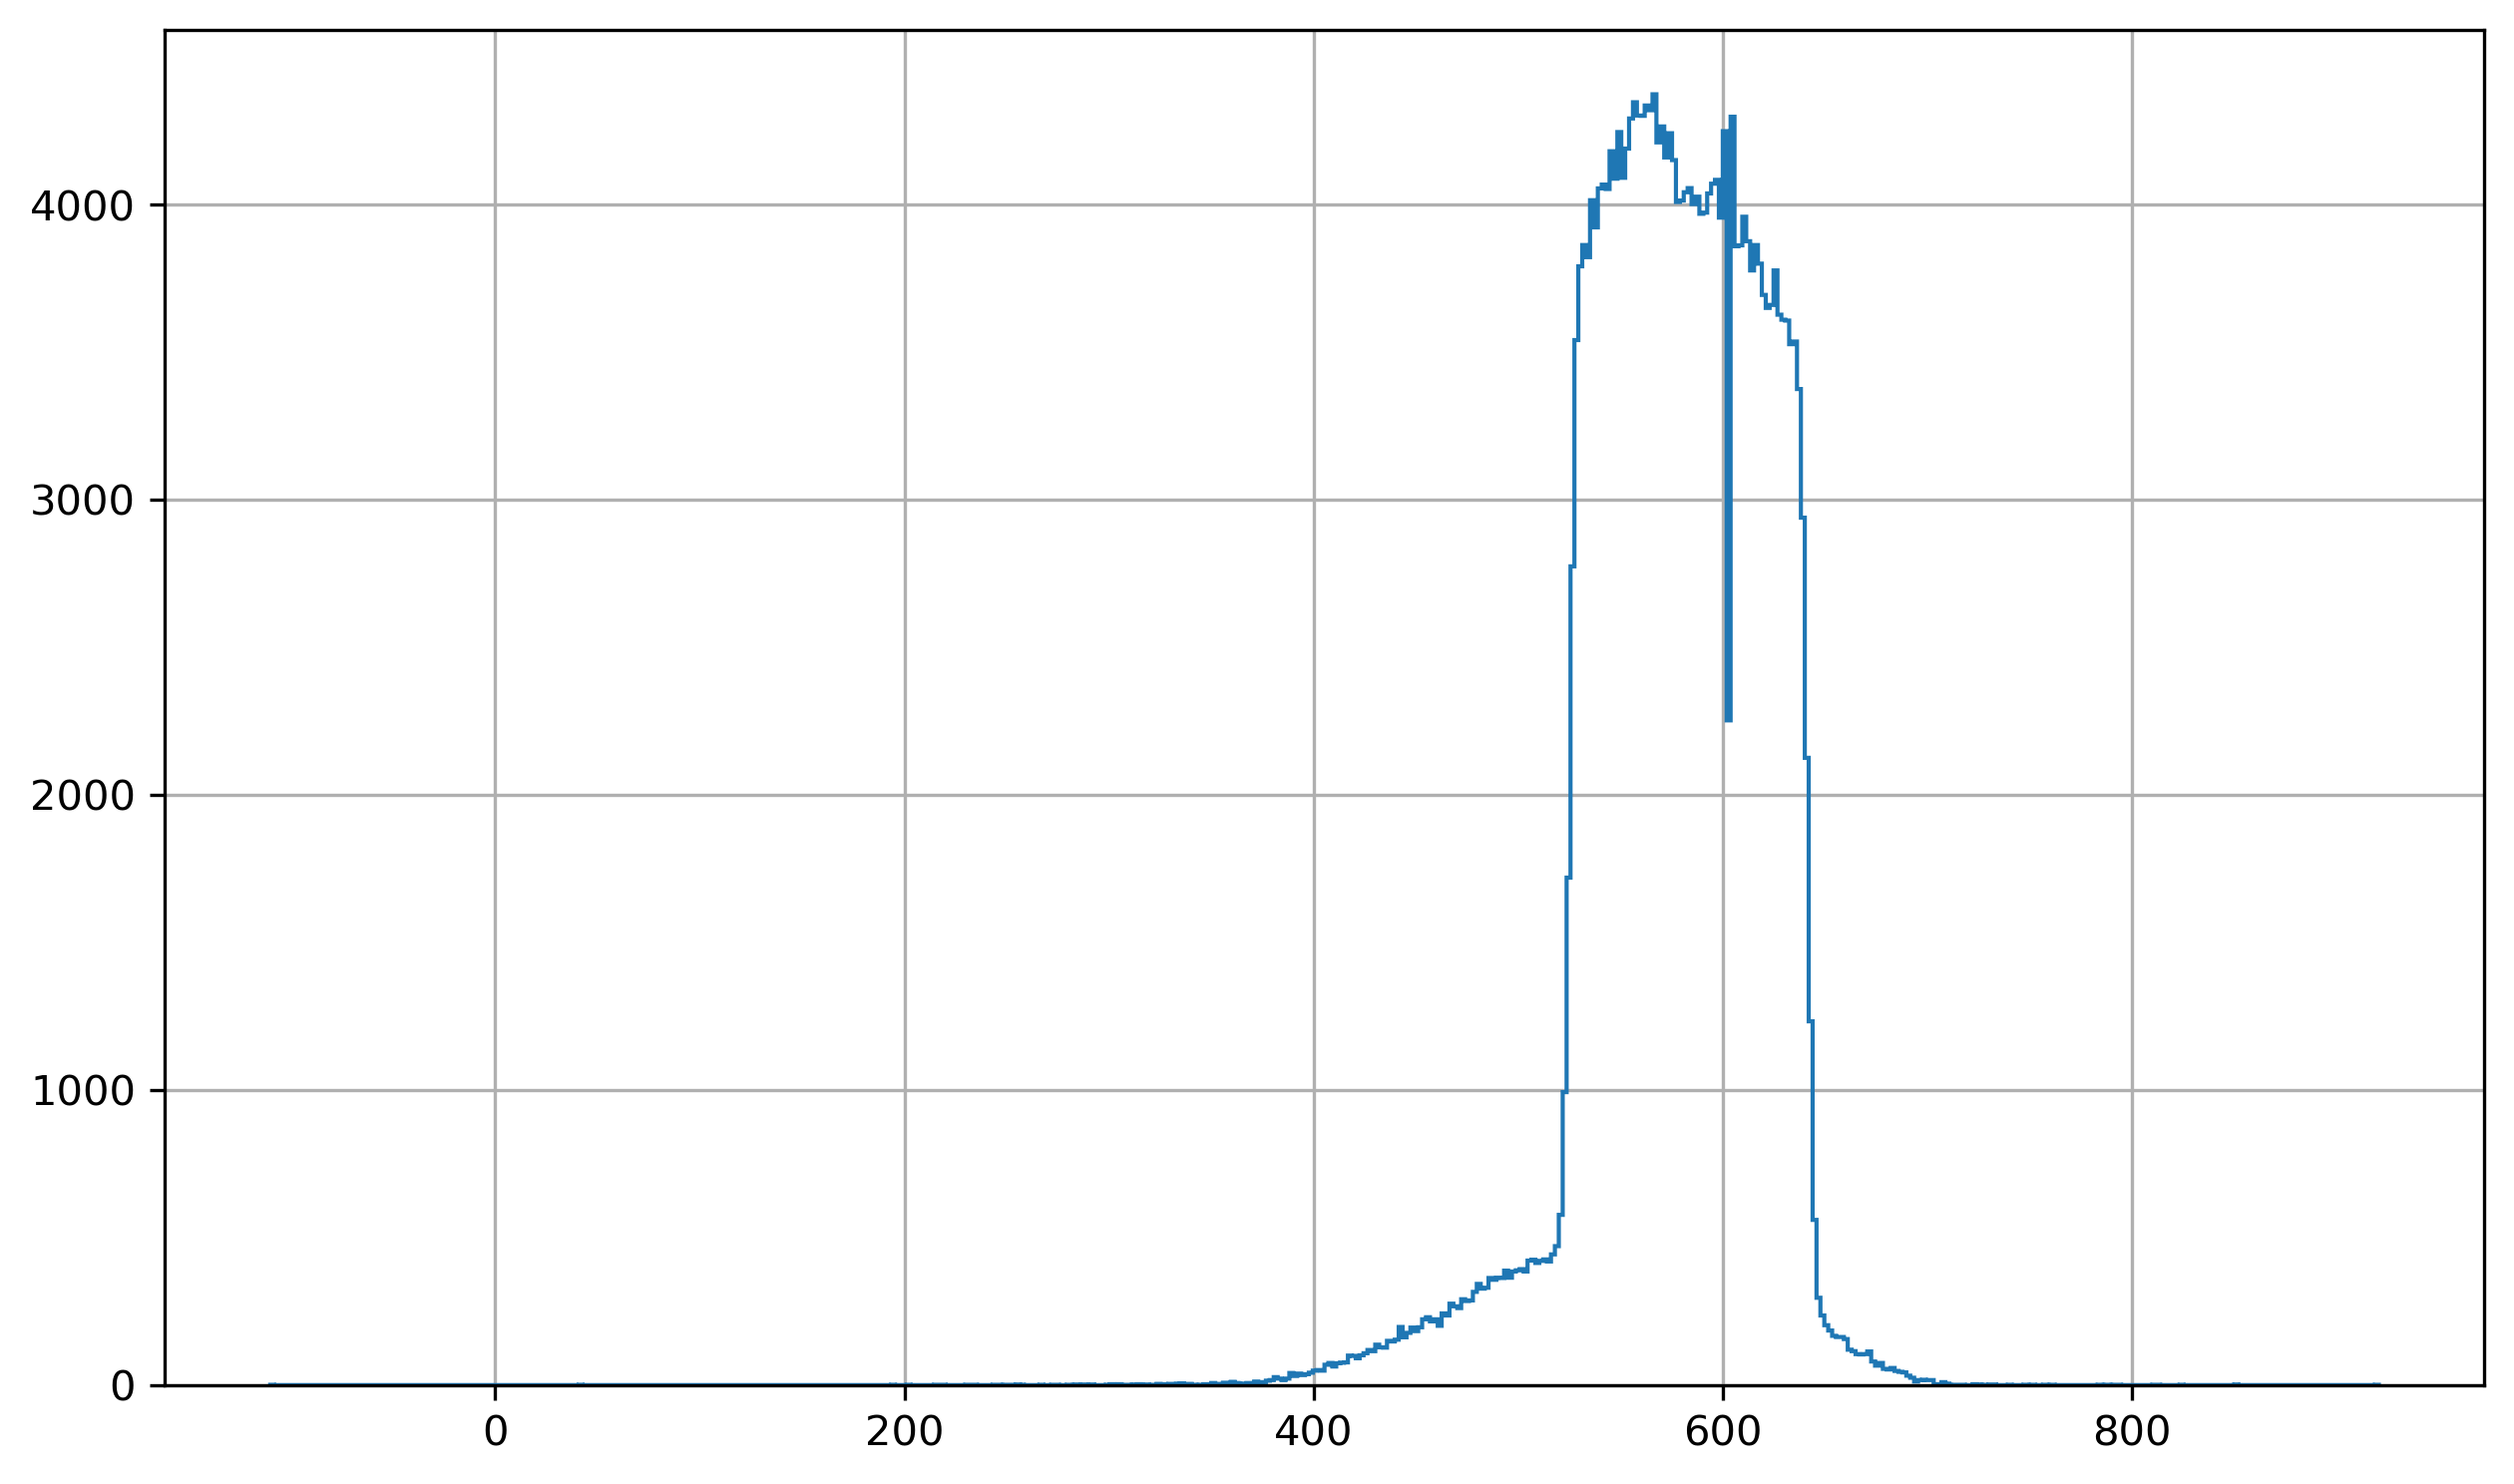

In [38]:
plot_histogram(df["S1"]["Xtr_2"])
# ax.semilogy()

In [7]:
pixel_size = 0.0185 #mm

# x and y limits of the plots
x_lim = {'left':450, 'right':650}
y_lim = {'bottom':200, 'top':500}

x_lim_mm = {key: value * pixel_size for key, value in x_lim.items()}
y_lim_mm = {key: value * pixel_size for key, value in y_lim.items()}

x_lim_small = {'left':525, 'right':650}
y_lim_small = {'bottom':200, 'top':325}

# I might have to define the bins a bit better because they depend on the limits of the data
# bins = (x_lim['right']-x_lim['left'], y_lim['top']-y_lim['bottom'])

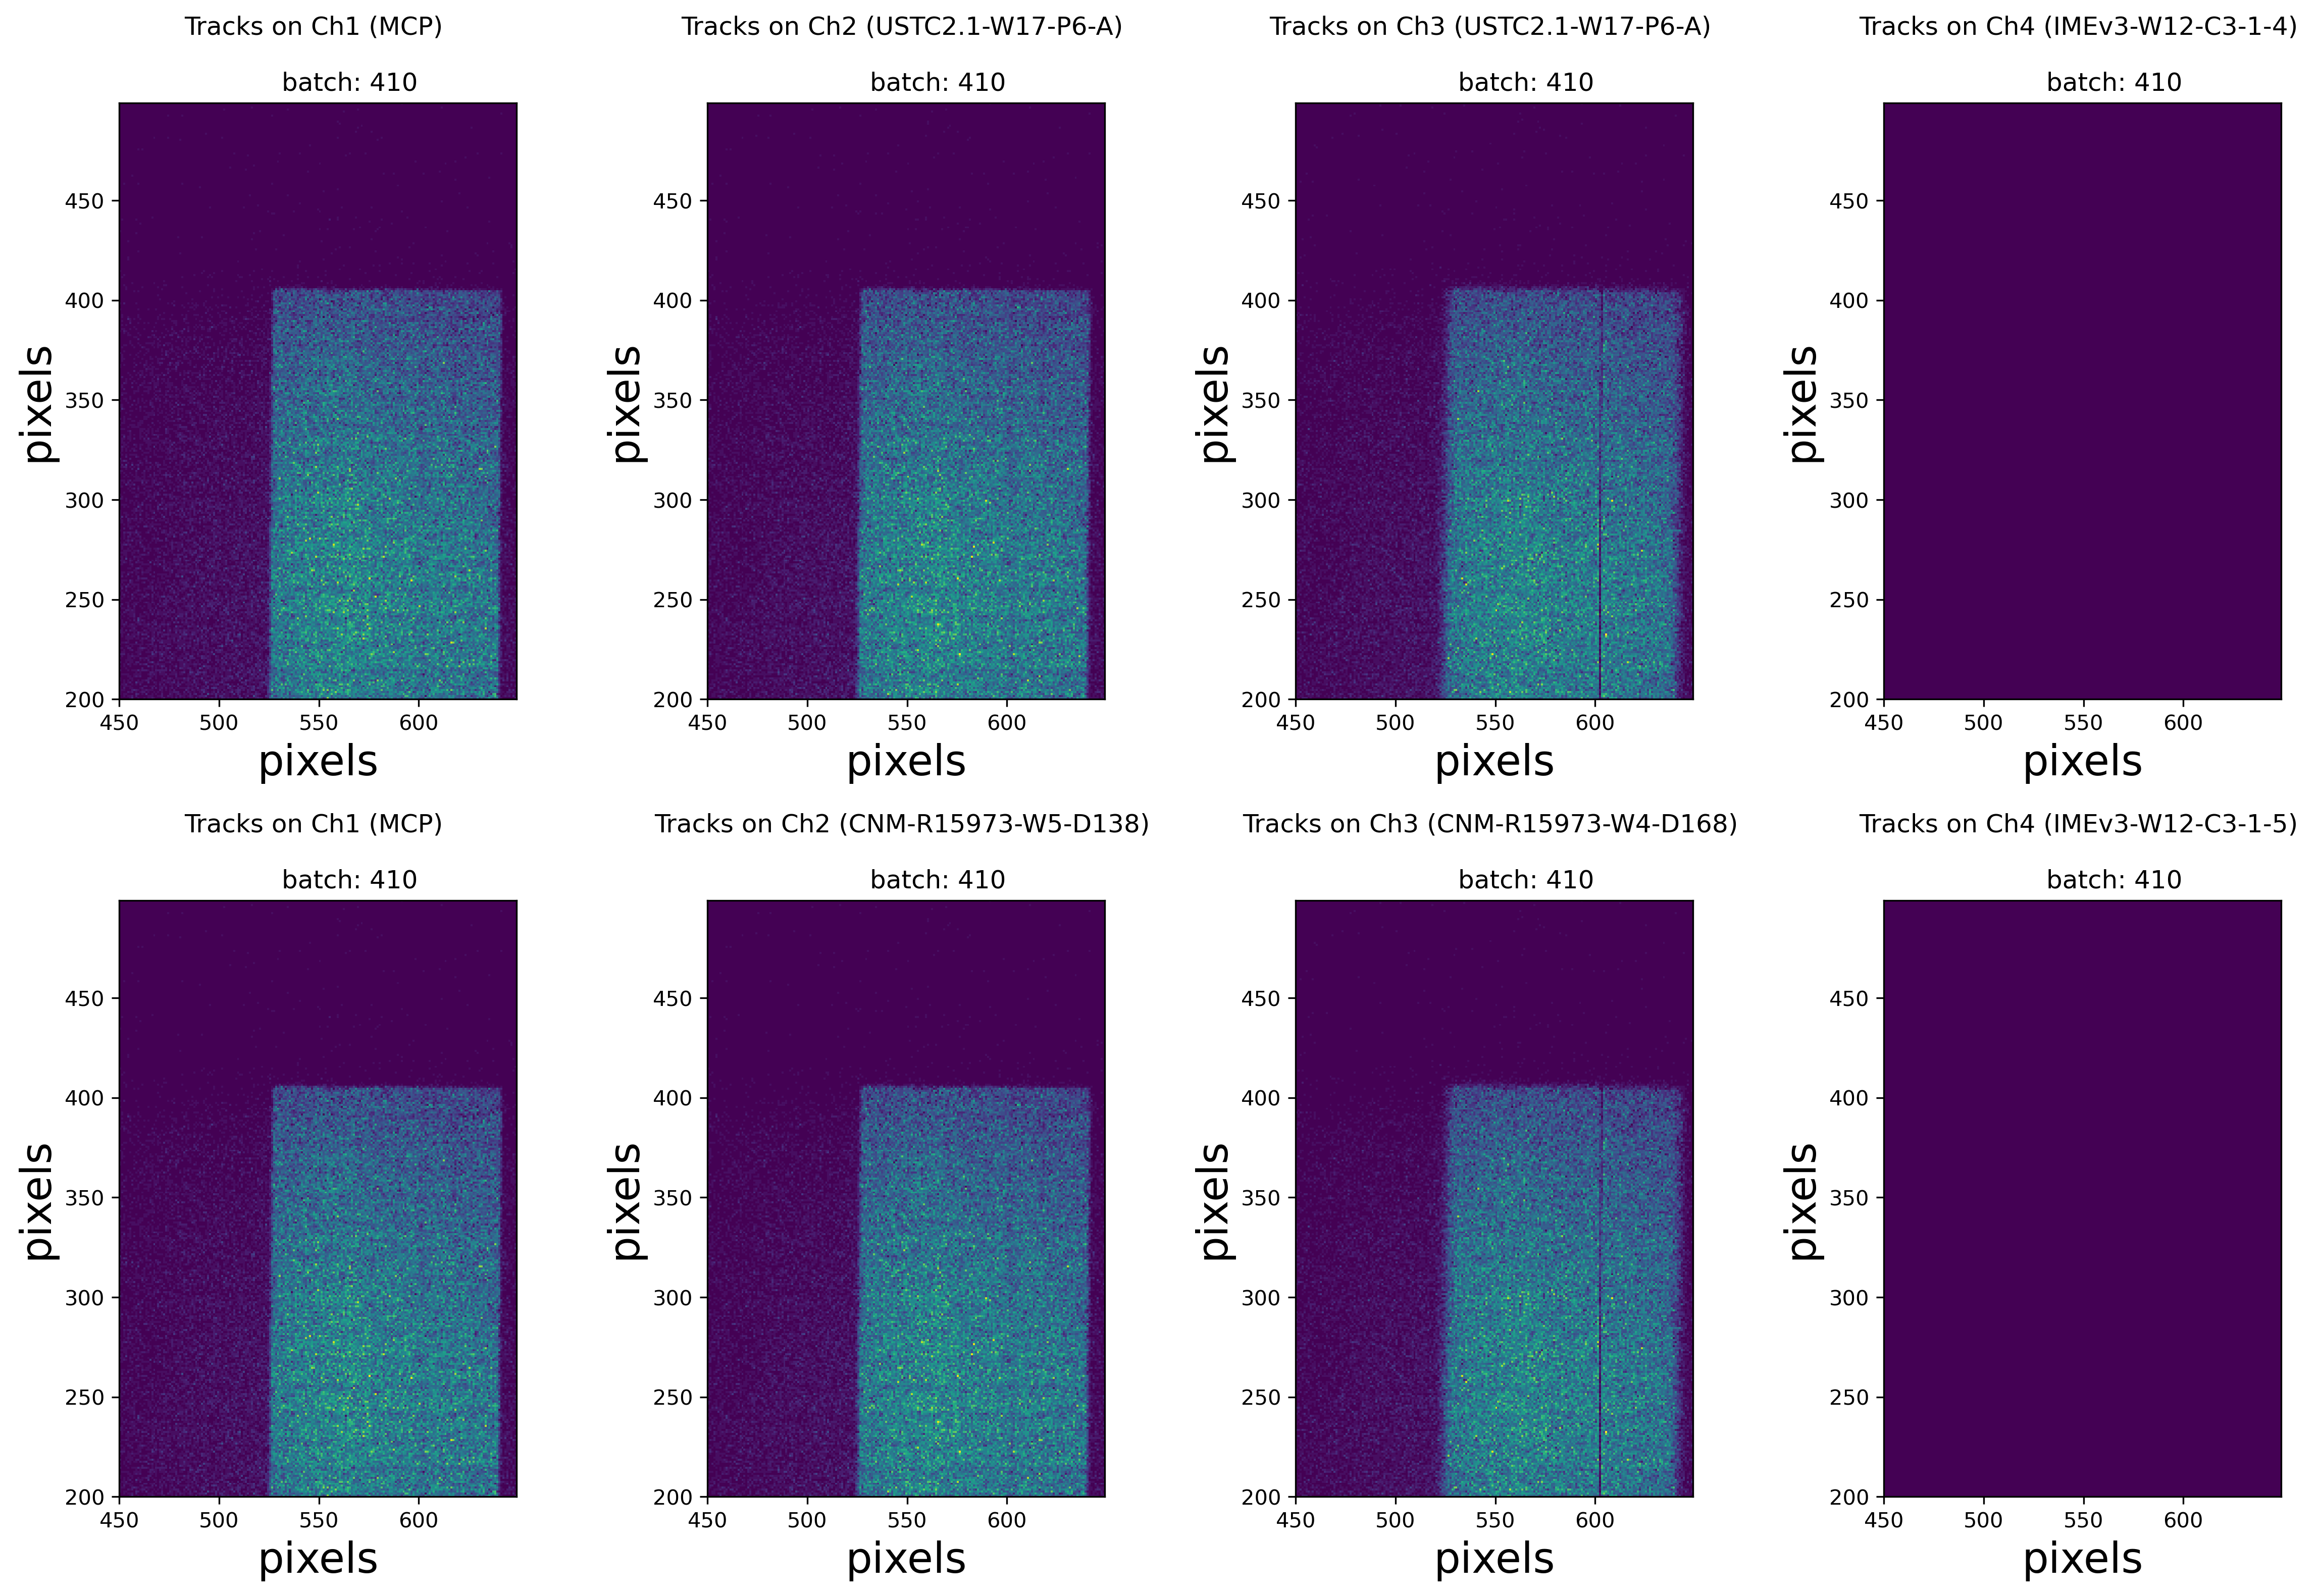

In [8]:
# choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
bins = (np.arange(x_lim['left'], x_lim['right'],1),
        np.arange(y_lim['bottom'], y_lim['top'],1))

# I wanna make this into a function

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10), dpi=300)#, sharex='all', sharey='all')
fig.tight_layout(w_pad=6, h_pad=6)

for idx, scope in enumerate(['S1','S2']):
    for i in (0,1,2,3):
        Xtr = df[scope][f"Xtr_{i}"]
        Ytr = df[scope][f"Ytr_{i}"]
        hist, _, _, _, = axes[idx,i].hist2d(Xtr, Ytr, bins=bins)
        axes[idx,i].set_title(f"""Tracks on Ch{i+1} ({sensors_list[this_batch][scope]['Ch'+f'{i+1}']}) \n 
        batch: {this_batch}""")
        axes[idx,i].set_aspect('equal')
        axes[idx,i].set_xlabel('pixels', fontsize=20)
        axes[idx,i].set_ylabel('pixels', fontsize=20)


In [117]:
sensors_list

{199: {'S1': {'Ch1': 'MCP',
   'Ch2': 'IMEv3-W12-C2-2-2',
   'Ch3': 'IMEv3-W12-C2-2-2',
   'Ch4': 'IMEv3-W12-C3-1-4'},
  'S2': {'Ch1': 'MCP',
   'Ch2': 'CNM-R15973-W5-D138',
   'Ch3': 'CNM-R15973-W4-D168',
   'Ch4': 'IMEv3-W12-C3-1-5'}},
 100: {'S1': {'Ch1': 'MCP',
   'Ch2': 'IMEv3-W12-C2-2-2',
   'Ch3': 'IMEv3-W12-C2-2-2',
   'Ch4': 'IMEv3-W12-C3-1-4'},
  'S2': {'Ch1': 'MCP',
   'Ch2': 'CNM-R15973-W5-D138',
   'Ch3': 'CNM-R15973-W4-D168',
   'Ch4': 'IMEv3-W12-C3-1-5'}},
 101: {'S1': {'Ch1': 'MCP',
   'Ch2': 'IMEv3-W12-C2-2-2',
   'Ch3': 'IMEv3-W12-C2-2-2',
   'Ch4': 'IMEv3-W12-C3-1-4'},
  'S2': {'Ch1': 'MCP',
   'Ch2': 'CNM-R15973-W5-D138',
   'Ch3': 'CNM-R15973-W4-D168',
   'Ch4': 'IMEv3-W12-C3-1-5'}},
 201: {'S1': {'Ch1': 'MCP',
   'Ch2': 'IMEv3-W12-C2-2-2',
   'Ch3': 'IMEv3-W12-C2-2-2',
   'Ch4': 'IMEv3-W12-C3-1-4'},
  'S2': {'Ch1': 'MCP',
   'Ch2': 'CNM-R15973-W5-D138',
   'Ch3': 'CNM-R15973-W4-D168',
   'Ch4': 'IMEv3-W12-C3-1-5'}},
 202: {'S1': {'Ch1': 'MCP',
   'Ch2': 'IMEv3-W12

In [10]:
# let's pause this because calculating peaks from histogram is way faster

# x_axis = np.linspace(-5,100,500)
# pulse_kde = gaussian_kde(dataset=df["S1"]["pulseHeight_1"].to_numpy()).evaluate(x_axis)

# peaks = find_peaks(pulse_kde)[0]
# minimun = find_peaks(-pulse_kde[peaks[0]:peaks[1]])
# print(x_axis[minimun[0]+peaks[0]])
# # minimum = find_min_kde(df["S1"]["pulseHeight_1"], x_axis)
# plt.plot(x_axis, pulse_kde)
# plt.plot(x_axis[peaks], pulse_kde[peaks], 'x')
# plt.plot(x_axis[minimun[0]+peaks[0]], pulse_kde[minimun[0]+peaks[0]], 'x')

['MCP', 'USTC2.1-W17-P6-A', 'USTC2.1-W17-P6-A', 'IMEv3-W12-C3-1-4']


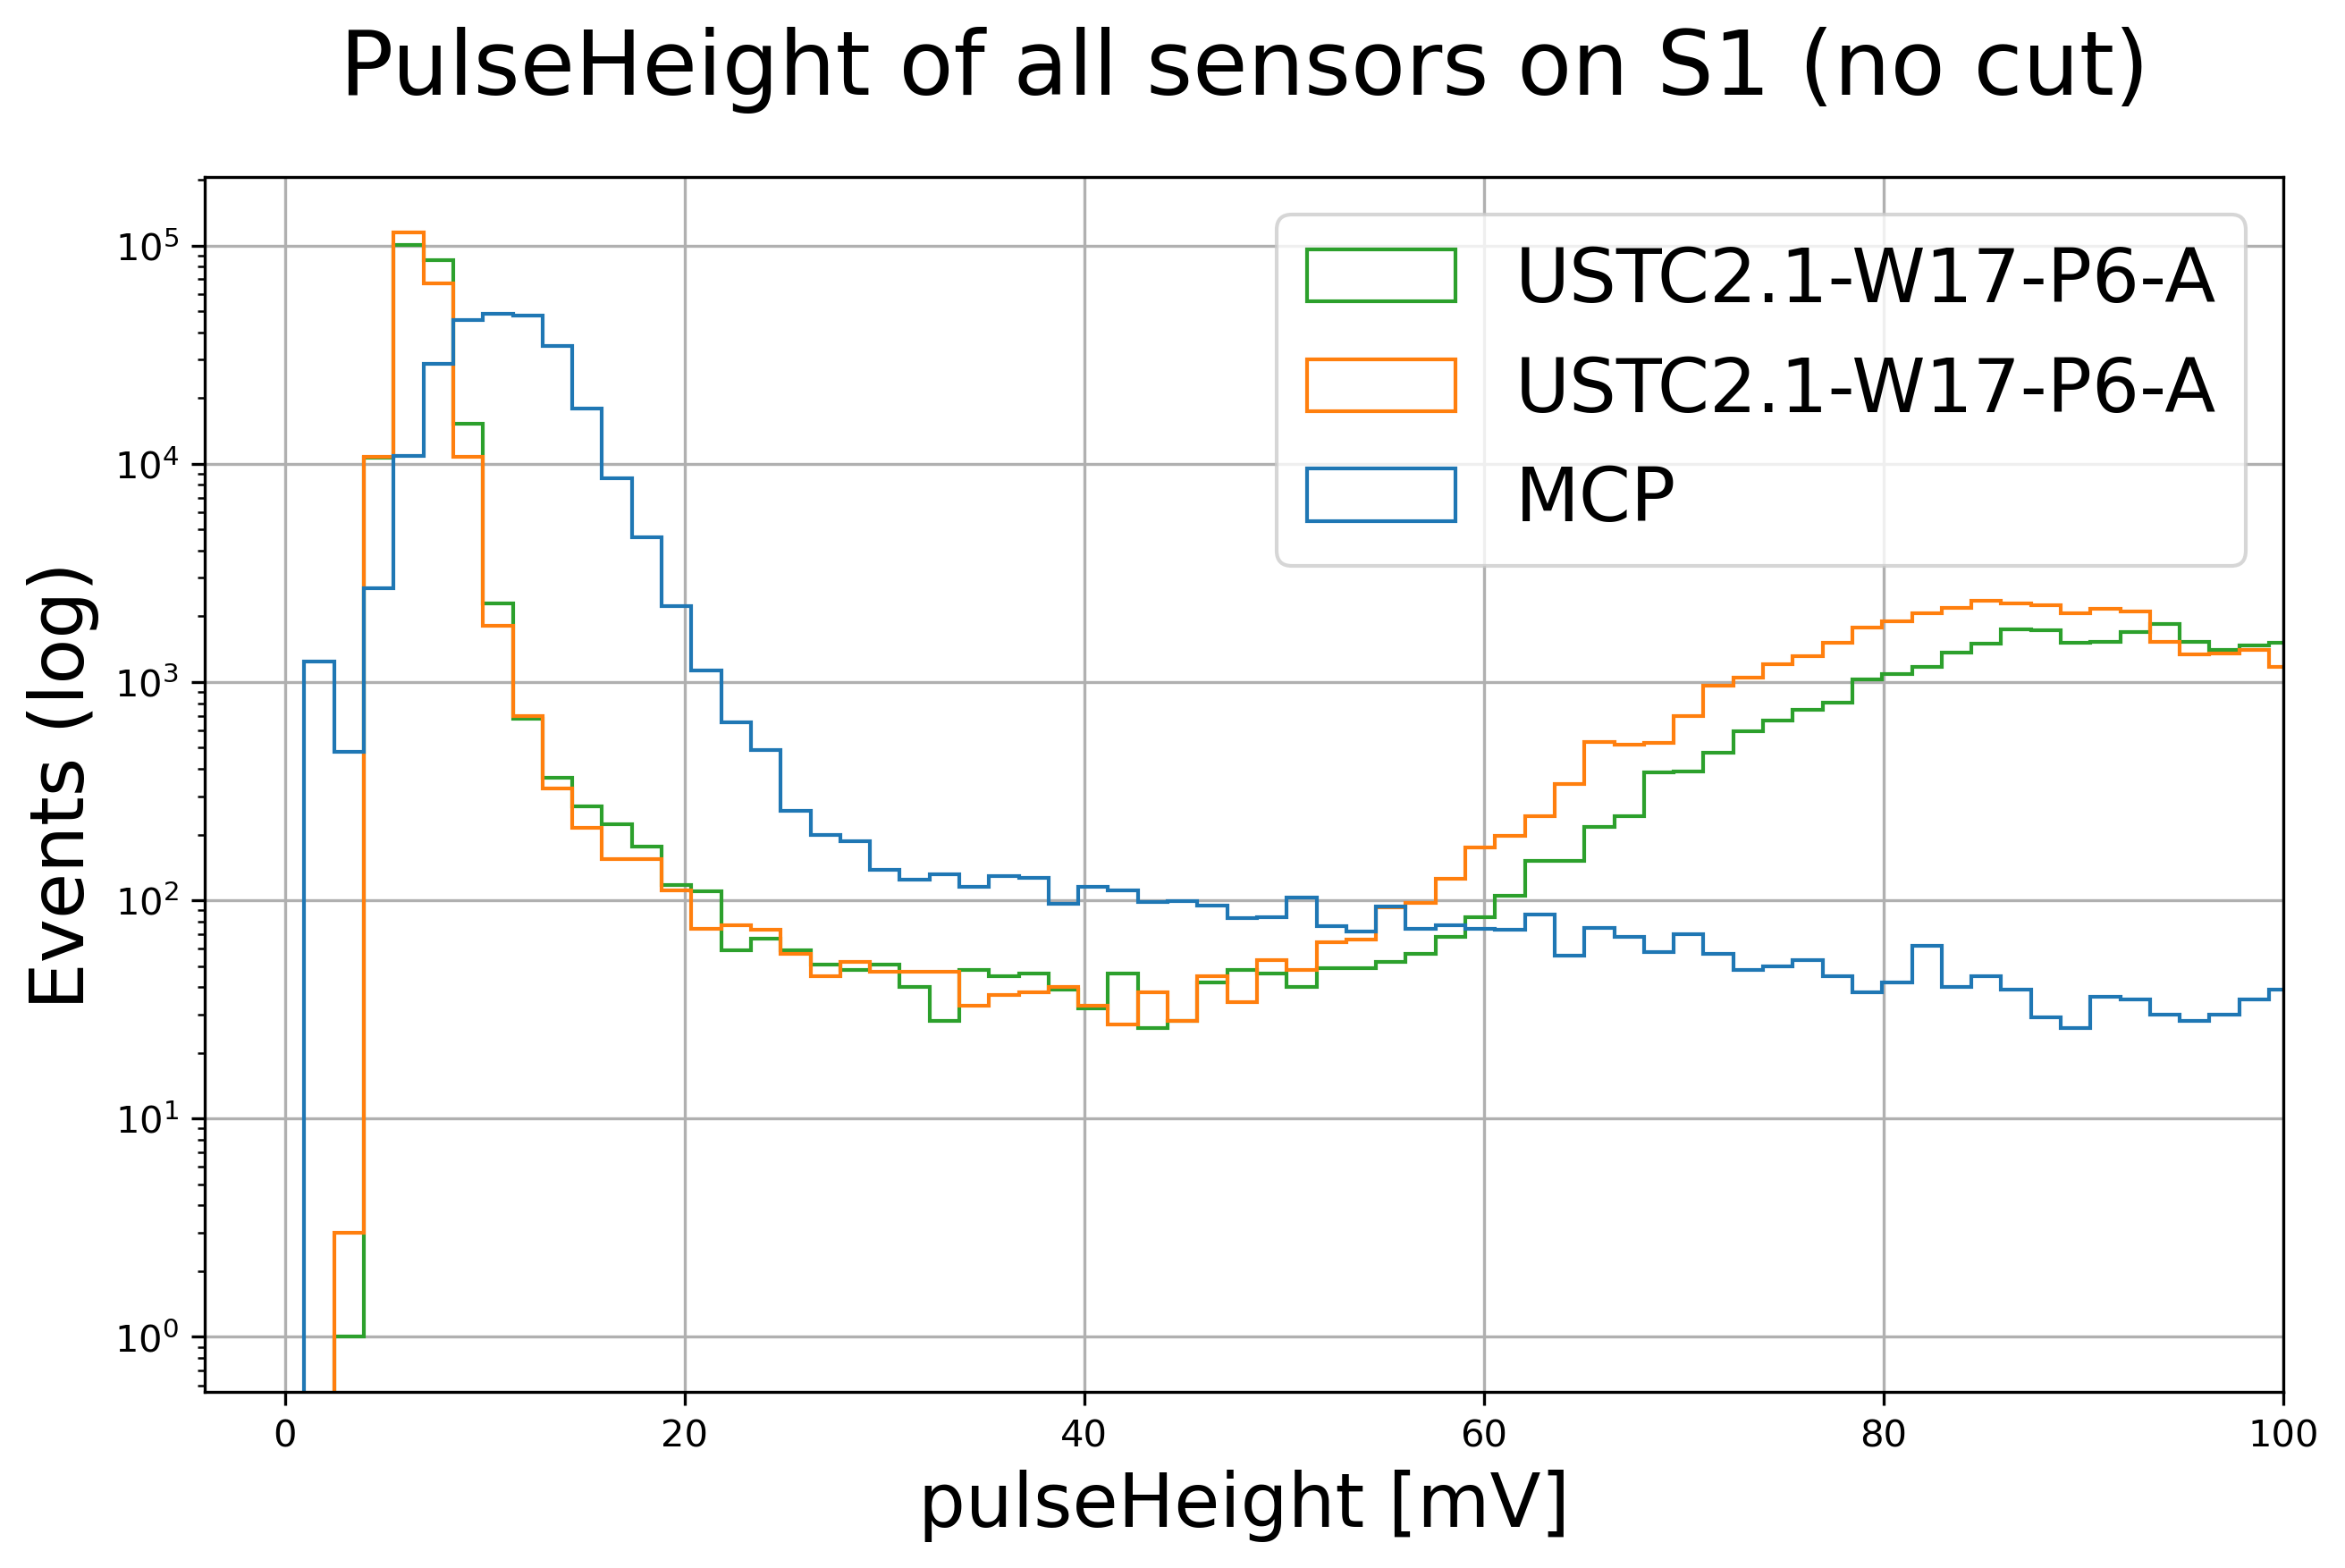

In [9]:
# Get the sensors names
this_scope = "S1"
these_sensors = list(sensors_list[this_batch][this_scope].values())
print(these_sensors)

# PulseHeight plot
fig, ax = plot_histogram(df[this_scope].loc[:,"pulseHeight_0":"pulseHeight_2"], label=these_sensors, bins=500)
ax.set_xlim(-4,100)
ax.semilogy()
ax.set_xlabel("pulseHeight [mV]", fontsize=20)
ax.set_ylabel("Events (log)", fontsize=20)
ax.set_title(f"PulseHeight of all sensors on {this_scope} (no cut)", fontsize=24, y=1.05)
ax.legend(fontsize=20)

# fig.savefig(f"various plots/pulseheight_plot_all_sensors_{this_batch}.jpg")

Text(0.5, 1.05, 'pulseHeight min between peaks, Ch2')

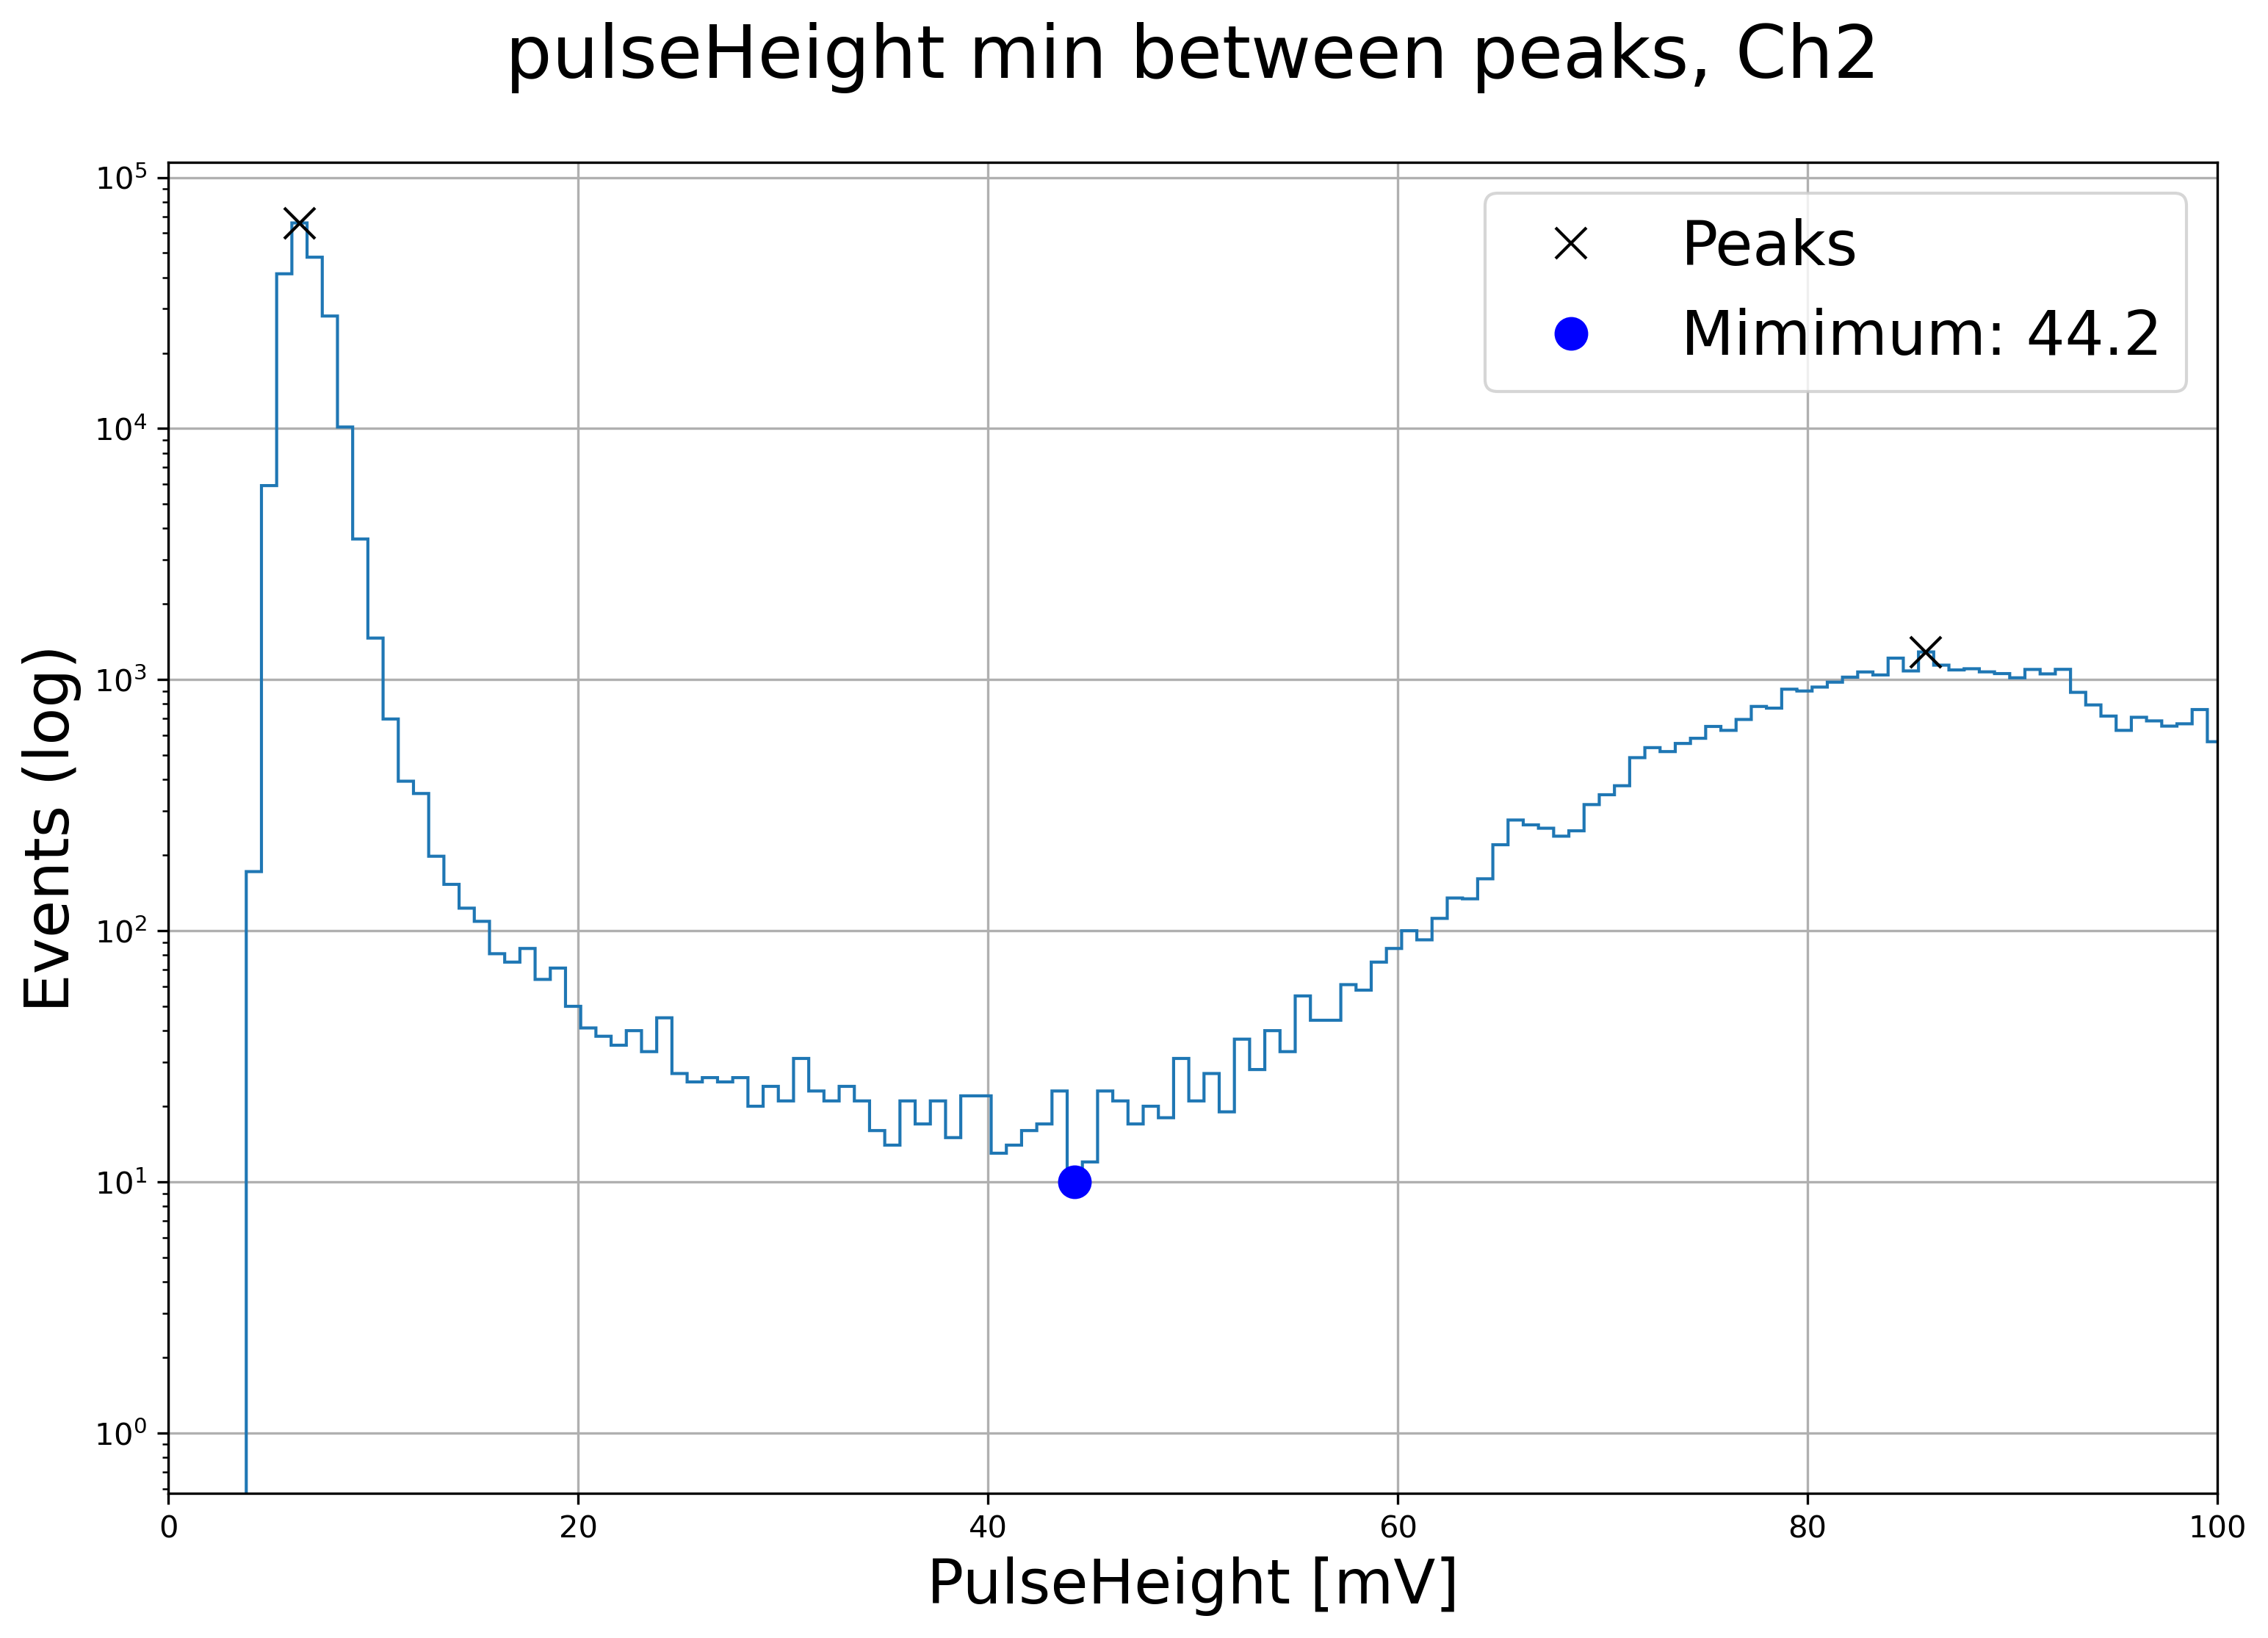

In [10]:
prominence = 500
distance = 20
bins = 1000
this_scope = 'S1'

fig, ax = plt.subplots(figsize=(12,8), dpi=300)
global_min = find_min_btw_peaks(df[this_scope]["pulseHeight_1"], bins, prominence, distance)
ax.set_xlim(0,100)
ax.set_xlabel("PulseHeight [mV]", fontsize=20)
ax.set_ylabel("Events (log)", fontsize=20)
ax.grid('--')
ax.semilogy()
ax.legend(fontsize=20)

ax.set_title(f"pulseHeight min between peaks, Ch2", fontsize=24, y=1.05)

# fig.savefig(f"various plots/pulseheight_min_between_picks_{this_batch}_{these_sensors[1]}.jpg")

In [11]:
this_scope = 'S1'
# initilize all the empty dicts ONLY if they don't already exist (so I can keep previous ones)
# might be useless later on
try: dict_mins[this_batch][this_scope] = {}
except:
    try:
        dict_mins[this_batch] = {}
        dict_mins[this_batch][this_scope] = {}
    except:
        dict_mins = {}
        dict_mins[this_batch] = {}
        dict_mins[this_batch][this_scope] = {}

prominence = 500
distance = 20 

# find the mimimum for each pulseHeight
for name in ['pulseHeight_1', 'pulseHeight_2']:
    print(name)
#     bins = 1000
    dict_mins[this_batch][this_scope][name] = find_min_btw_peaks(df[this_scope][name], bins, prominence, distance, plot=False)
    print("min:", dict_mins[this_batch][this_scope][name])

dict_mins

pulseHeight_1
min: 44.23841
pulseHeight_2
min: 44.970104


{410: {'S1': {'pulseHeight_1': 44.23841, 'pulseHeight_2': 44.970104}}}

In [12]:
transimpedance = 4700


In [13]:
# Filter condi-tions
min_1 = dict_mins[this_batch][this_scope]["pulseHeight_1"]
min_2 = dict_mins[this_batch][this_scope]["pulseHeight_2"]
filter_1 = (df[this_scope]["pulseHeight_1"]>min_1).combine(df[this_scope]["pulseHeight_1"]<350, my_and)
filter_2 = (df[this_scope]["pulseHeight_2"]>min_2).combine(df[this_scope]["pulseHeight_2"]<350, my_and)

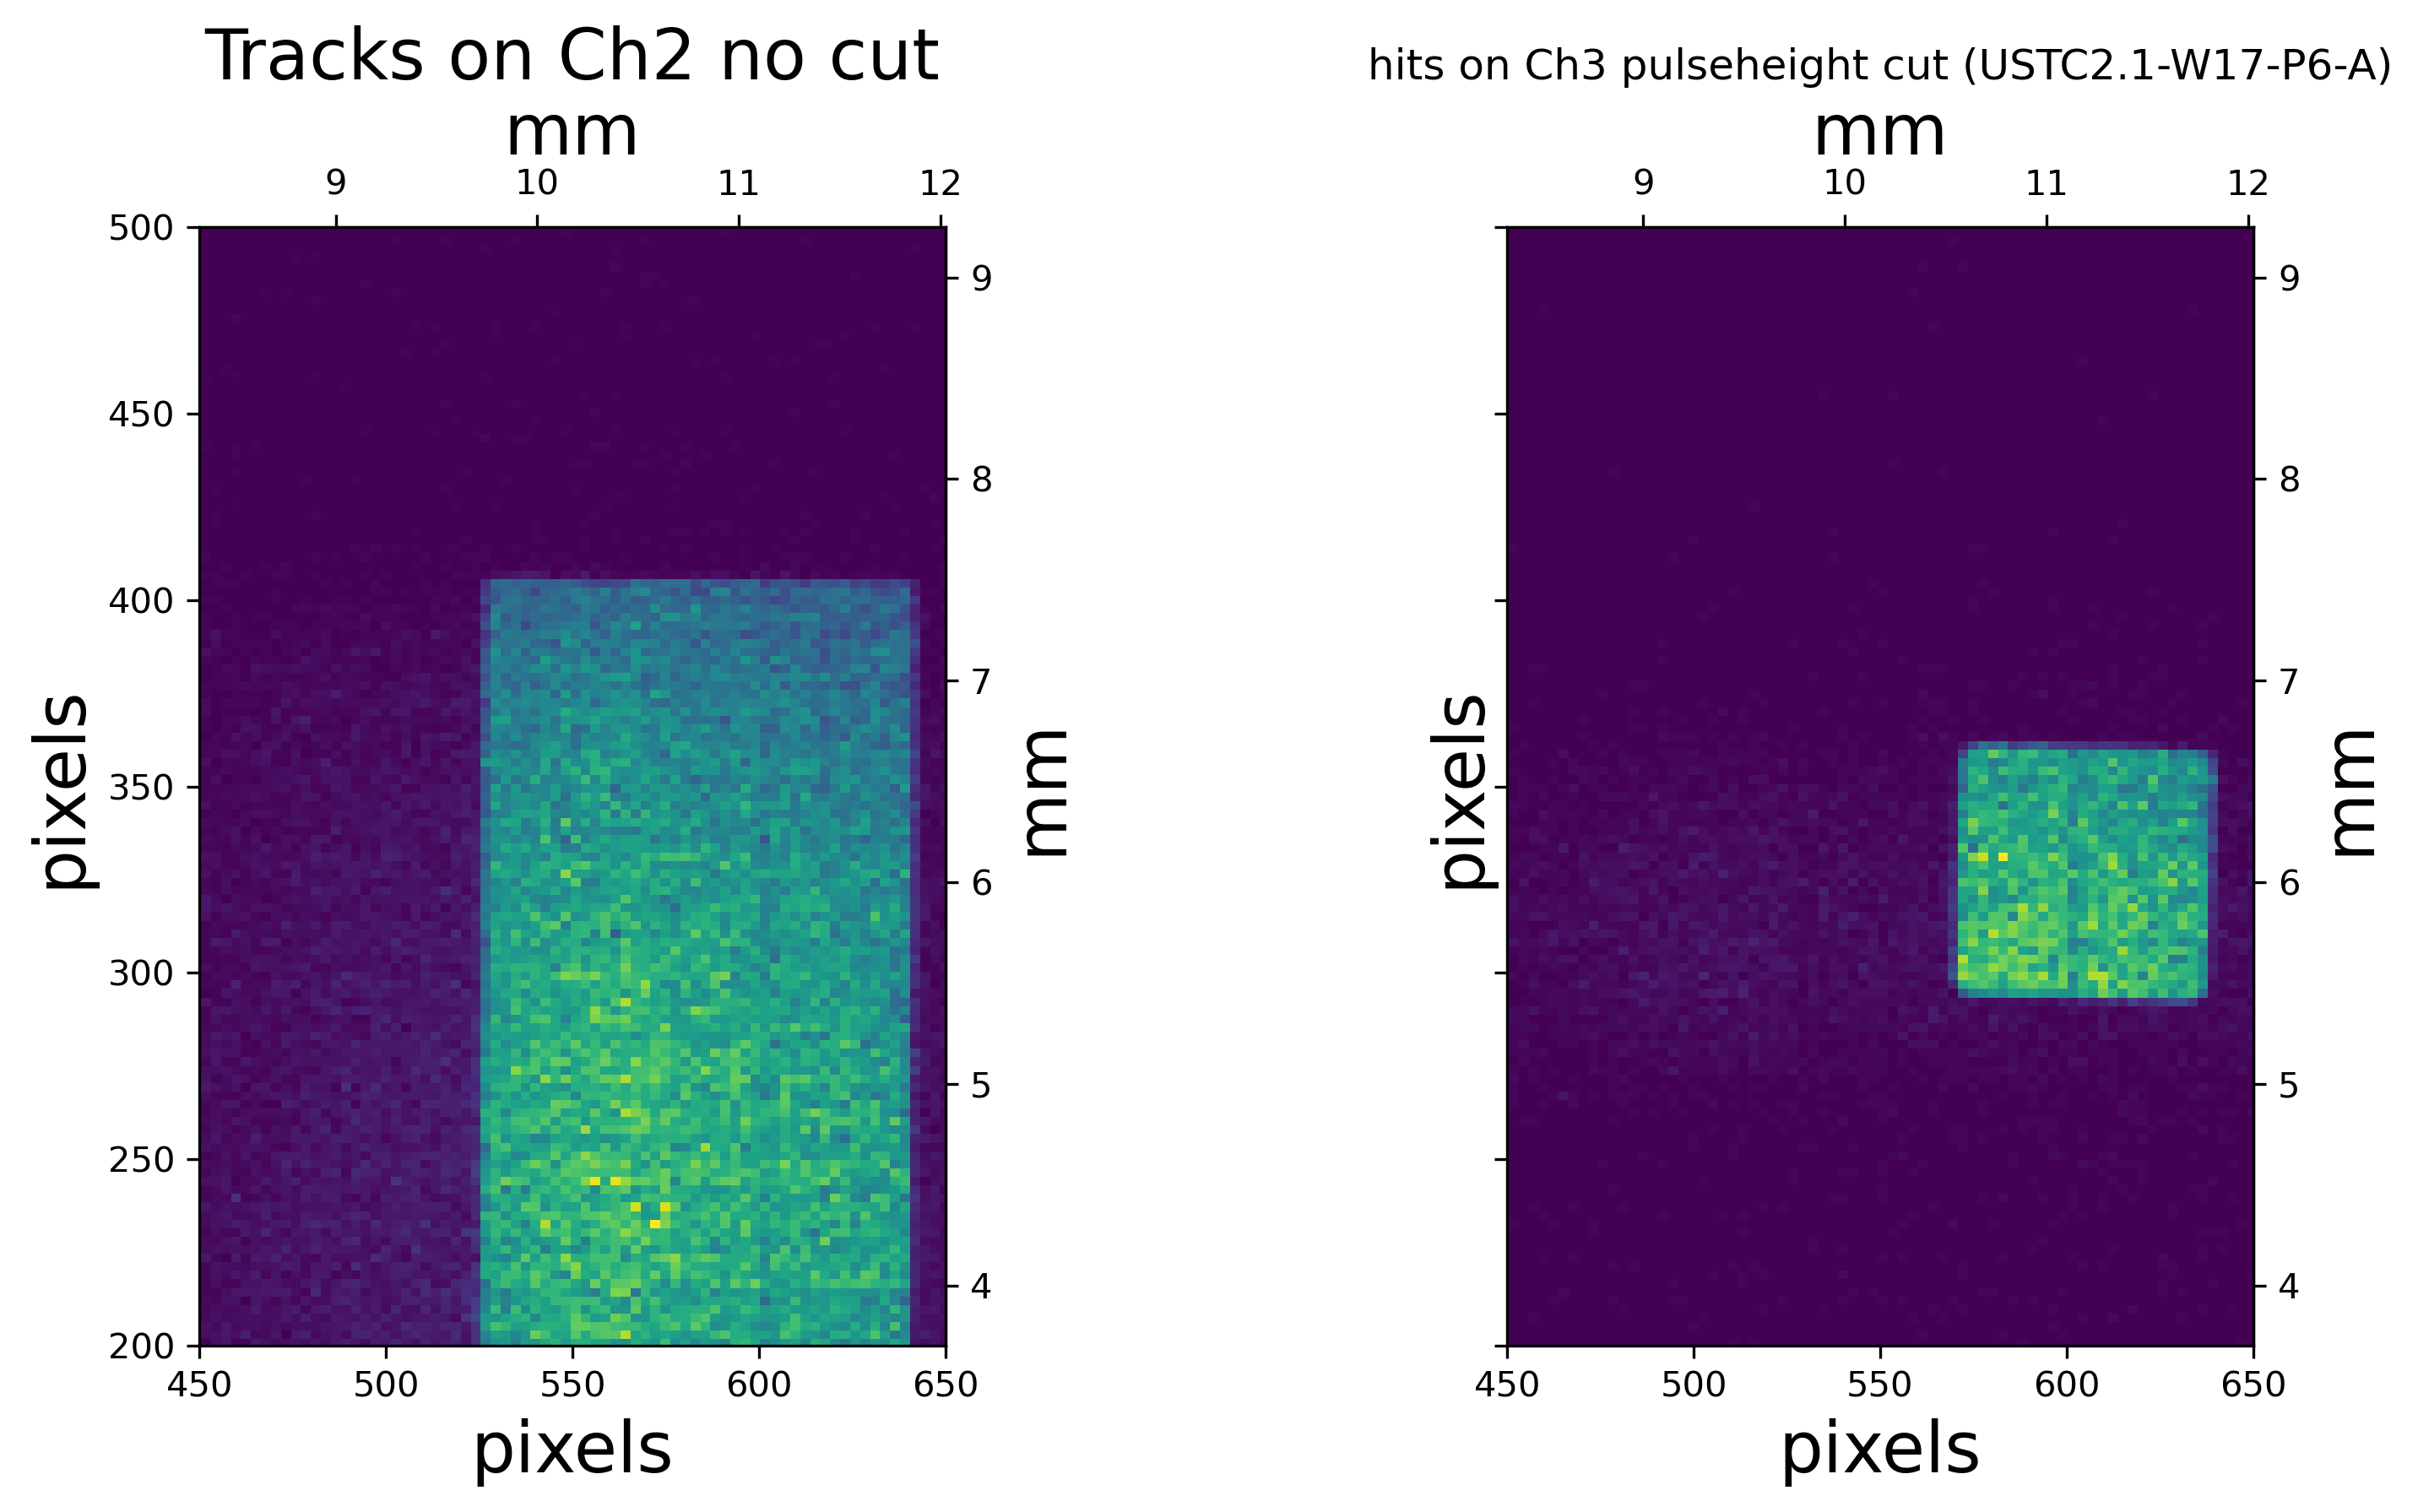

In [15]:
this_scope = 'S1'
bins = (200,200)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=300, sharex='all', sharey='all')
fig.tight_layout(w_pad=6)

Xtr_0 = df[this_scope]["Xtr_0"]#*pixel_size
Ytr_0 = df[this_scope]["Ytr_0"]#*pixel_size
# hist, x_bins, y_bins, _ = ax[0].hist2d(Xtr_0, Ytr_0, bins=bins) # set the same bins for all plots
# axes[0].set_title(f"hits on Ch1 no cut ({sensors_list[this_batch][this_scope]['Ch1']})")

Xtr_1 = df[this_scope]["Xtr_1"]#*pixel_size
Ytr_1 = df[this_scope]["Ytr_1"]#*pixel_size
hist, x_bins, y_bins, _ = axes[0].hist2d(Xtr_1, Ytr_1, bins=bins) # set the same bins for all plots
axes[0].set_title(f"Tracks on Ch2 no cut", fontsize=20)

# Xtr_1cut = df[this_scope]["Xtr_1"].iloc[np.where(filter_1)]#*pixel_size
# Ytr_1cut = df[this_scope]["Ytr_1"].iloc[np.where(filter_1)]#*pixel_size
# axes[1].hist2d(Xtr_1cut, Ytr_1cut, bins=(x_bins,y_bins))
# axes[1].set_title(f"Tracks on Ch2 pulseheight cut", fontsize=20)

Xtr_2cut = df[this_scope]["Xtr_2"].iloc[np.where(filter_2)]#*pixel_size
Ytr_2cut = df[this_scope]["Ytr_2"].iloc[np.where(filter_2)]#*pixel_size
axes[1].hist2d(Xtr_2cut, Ytr_2cut, bins=(x_bins,y_bins))
axes[1].set_title(f"hits on Ch3 pulseheight cut ({sensors_list[this_batch][this_scope]['Ch3']})")

# fig.suptitle(f'Hit positions on batch 301', size=16)

for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlim(**x_lim)
    ax.set_ylim(**y_lim)
    ax.set_xlabel('pixels', fontsize=20)
    ax.set_ylabel('pixels', fontsize=20)
    secx = ax.secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secy = ax.secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secx.set_xlabel('mm', fontsize=20)
    secy.set_ylabel('mm', fontsize=20)

# fig.savefig(f"various plots/hits_on_USTC_{this_batch}_pulseheight_cut.jpg", bbox_inches="tight")

In [20]:
# figure out the geometry cut and put it into a dict
edges = {}
edges["Ch2"] = {}

edges["Ch2"]["left"], edges["Ch2"]["right"] = find_edges(Xtr_1cut) # previous Xtr cut
edges["Ch2"]["bottom"], edges["Ch2"]["top"] = find_edges(Ytr_1cut)
xgeometry_1 = (df[this_scope]["Xtr_1"]>edges["Ch2"]["left"]).combine((
                df[this_scope]["Xtr_1"]<edges["Ch2"]["right"]), my_and)
ygeometry_1 = (df[this_scope]["Ytr_1"]>edges["Ch2"]["bottom"]).combine((
                df[this_scope]["Ytr_1"]<edges["Ch2"]["top"]), my_and) 
geometry_1 = xgeometry_1.combine(ygeometry_1, my_and)

edges["Ch3"] = {}
edges["Ch3"]["left"], edges["Ch3"]["right"] = find_edges(Xtr_2cut) 
edges["Ch3"]["bottom"], edges["Ch3"]["top"] = find_edges(Ytr_2cut)
xgeometry_2 = (df[this_scope]["Xtr_2"]>edges["Ch3"]["left"]).combine((
                df[this_scope]["Xtr_2"]<edges["Ch3"]["right"]), my_and)
ygeometry_2 = (df[this_scope]["Ytr_2"]>edges["Ch3"]["bottom"]).combine((
                df[this_scope]["Ytr_2"]<edges["Ch3"]["top"]), my_and) 
geometry_2 = xgeometry_2.combine(ygeometry_2, my_and)

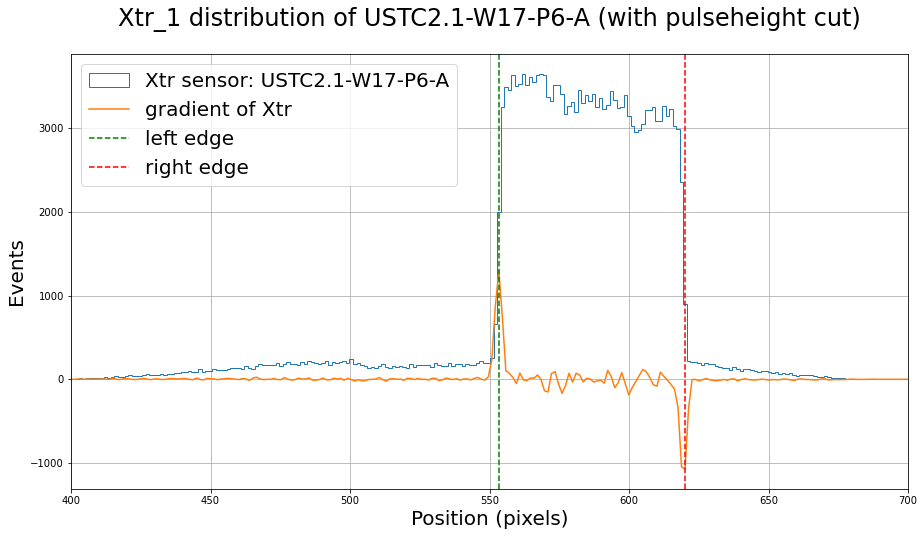

In [21]:
left_edge, right_edge = find_edges(Xtr_1cut)

fig, ax = plt.subplots(figsize=(15,8))
hist, bins, _ = plt.hist(Xtr_1cut, bins='auto', histtype='step', label=f'Xtr sensor: {these_sensors[1]}')
ax.plot((bins[:-1]+bins[1:])/2, np.gradient(hist), label='gradient of Xtr')
ax.axvline(left_edge, color='g', linestyle='--', label='left edge')
ax.axvline(right_edge, color='r', linestyle='--', label='right edge')
ax.set_title(f"Xtr_1 distribution of {these_sensors[1]} (with pulseheight cut)", fontsize=24, y=1.05)
ax.set_xlim(400,700)
ax.set_xlabel("Position (pixels)", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.grid('--')
ax.legend(fontsize=20, loc='upper left')

fig.savefig(f"various plots/locating_edges_Xtr_of_{these_sensors[1]}.jpg")

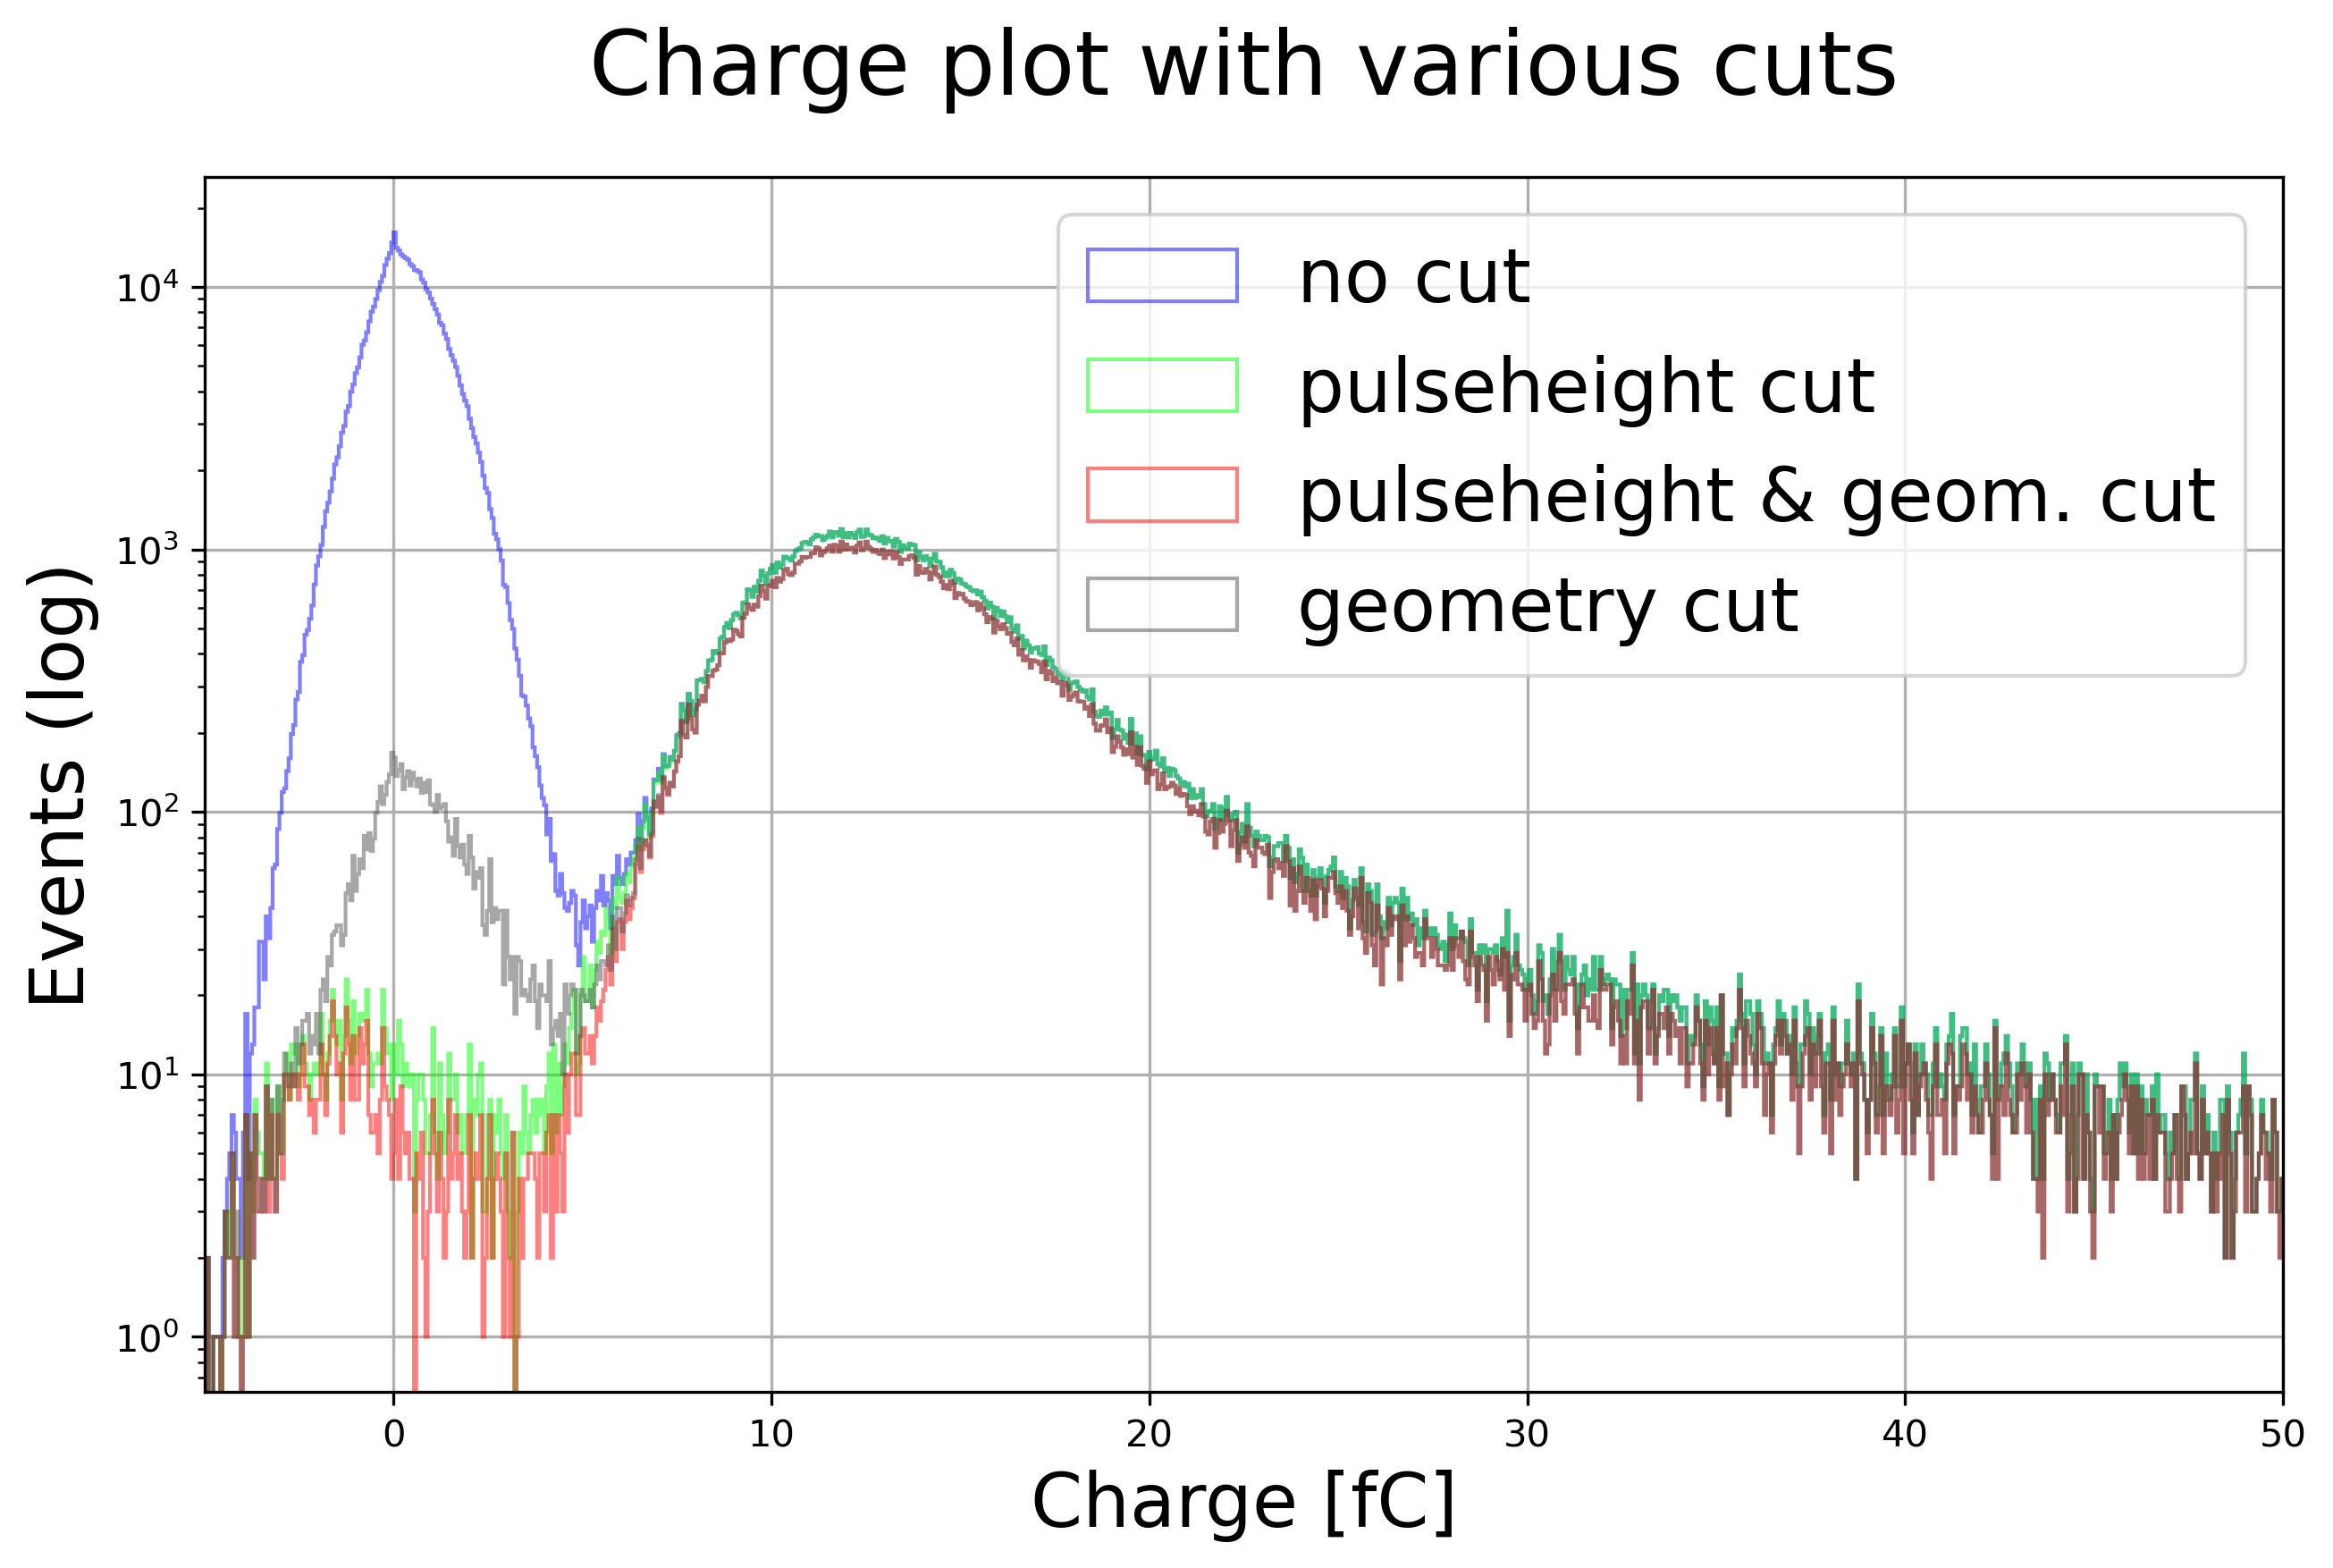

In [22]:
data_pulse_filter = df["S1"]["charge_2"].iloc[np.where(filter_2)]/transimpedance
data_pulse_geo_filter = df["S1"]["charge_2"].iloc[np.where(filter_2 & geometry_2)]/transimpedance
data_geo_filter = df["S1"]["charge_2"].iloc[np.where(geometry_2)]/transimpedance

# I need to figure out how to combine colors into nice thing
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
hist, bins_for_all, _ = ax.hist(df["S1"]["charge_2"]/transimpedance, bins='auto', label="no cut", histtype='step', alpha=.5, color='#0000ff')
add_histogram(ax, data_pulse_filter, bins=bins_for_all, label="pulseheight cut", alpha=.5, color='#00ff00')
add_histogram(ax, data_pulse_geo_filter, bins=bins_for_all, label="pulseheight & geom. cut", alpha=.5, color='#ff0000')
add_histogram(ax, data_geo_filter, bins=bins_for_all, label="geometry cut", alpha=.5, color='#505050') # #ffff00
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events (log)", fontsize=20)
ax.set_title(f"Charge plot with various cuts", fontsize=24,y=1.05)
ax.grid('--')
ax.set_xlim(-5,50)
ax.semilogy()
ax.legend(fontsize=20)

fig.savefig(f"various plots/charge_plot_various_cuts_{this_batch}.jpg")

In [23]:
print(find_edges(Xtr_1cut), find_edges(Ytr_1cut))
# (right_edge-left_edge)*pixel_size
# (top_edge-bottom_edge)*pixel_size

(553.314325755407, 620.0606368009956) (233.12319022860817, 299.96337069760455)


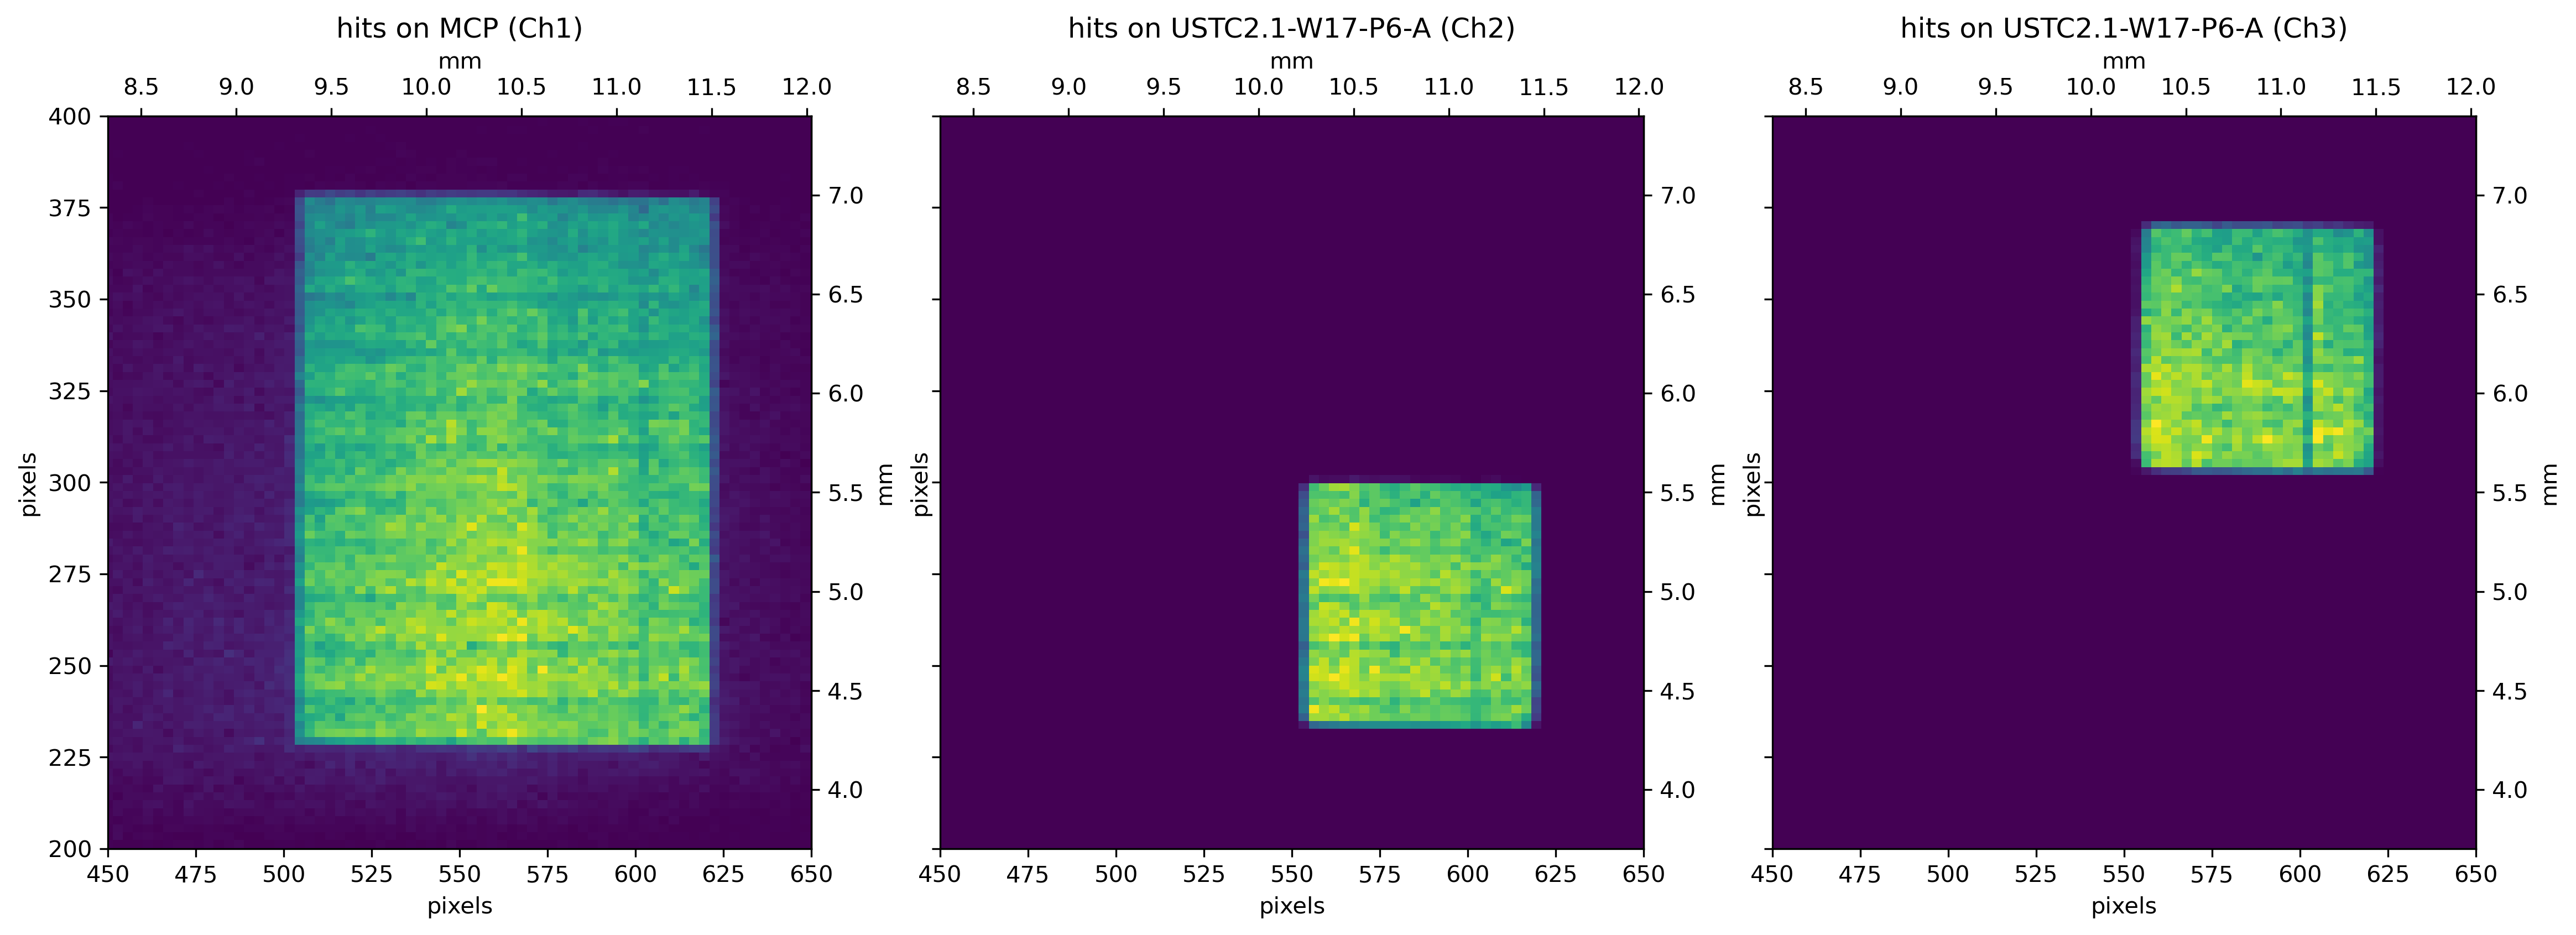

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), dpi=300, sharex='all', sharey='all')
fig.tight_layout(w_pad=4)

Xtr_0 = df[this_scope]["Xtr_1"]#*pixel_size
Ytr_0 = df[this_scope]["Ytr_1"]#*pixel_size
ax[0].hist2d(Xtr_0, Ytr_0, bins=(x_bins, y_bins))
ax[0].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch1']} (Ch1)")

Xtr_1geo = df[this_scope]["Xtr_1"].iloc[np.where(filter_1 & geometry_1)]#*pixel_size
Ytr_1geo = df[this_scope]["Ytr_1"].iloc[np.where(filter_1 & geometry_1)]#*pixel_size
ax[1].hist2d(Xtr_1geo, Ytr_1geo, bins=(x_bins, y_bins))
ax[1].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2)")

Xtr_2cut = df[this_scope]["Xtr_2"].iloc[np.where(filter_2 & geometry_2)]#*pixel_size
Ytr_2cut = df[this_scope]["Ytr_2"].iloc[np.where(filter_2 & geometry_2)]#*pixel_size
ax[2].hist2d(Xtr_2cut, Ytr_2cut, bins=(x_bins, y_bins))
ax[2].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch3']} (Ch3)")

# fig.suptitle(f'Hit positions on batch 301', size=16)

for ax_single in ax:
#     ax_single.axis('equal')
    ax_single.set_xlim(**x_lim)
    ax_single.set_ylim(**y_lim)
    ax_single.set_xlabel('pixels')
    ax_single.set_ylabel('pixels')
    secx = ax_single.secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secy = ax_single.secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secx.set_xlabel('mm')
    secy.set_ylabel('mm')

fig.savefig(f"various plots/hits_on_USTC_{this_batch}_geometry_cut.jpg", bbox_inches="tight")

pixel bins intervals: X=[553.0, 620.0], Y=[233.0, 300.0]


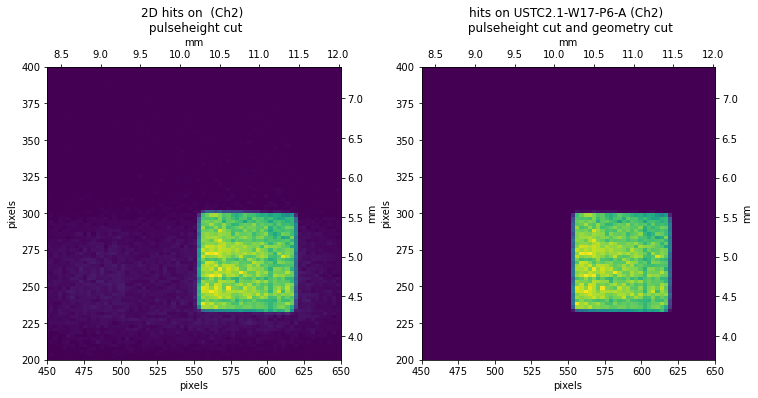

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.tight_layout(w_pad=5)

Xtr_1cut = df[this_scope]["Xtr_1"].iloc[np.where(filter_1)]#*pixel_size
Ytr_1cut = df[this_scope]["Ytr_1"].iloc[np.where(filter_1)]#*pixel_size

ax[0].hist2d(Xtr_1cut, Ytr_1cut, bins=(x_bins,y_bins))
# ax[0].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2) \n pulseheight cut")
ax[0].set_title(f"2D hits on  (Ch2) \n pulseheight cut")

# Define bin edges with a bin width of 1
x_bins_pixels = np.arange(np.round(edges["Ch2"]["left"]), np.round(edges["Ch2"]["right"])+1, 1)
y_bins_pixels = np.arange(np.round(edges["Ch2"]["bottom"]), np.round(edges["Ch2"]["top"])+1, 1)
print(f"pixel bins intervals: X=[{min(x_bins_pixels)}, {max(x_bins_pixels)}], \
Y=[{min(y_bins_pixels)}, {max(y_bins_pixels)}]")

Xtr_1geo = df[this_scope]["Xtr_1"].iloc[np.where(geometry_1 & filter_1)]#*pixel_size
Ytr_1geo = df[this_scope]["Ytr_1"].iloc[np.where(geometry_1 & filter_1)]#*pixel_size
ax[1].hist2d(Xtr_1geo, Ytr_1geo, bins=(x_bins, y_bins))
ax[1].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2) \n pulseheight cut and geometry cut")

for ax_single in ax:
    ax_single.set_aspect('equal')
    ax_single.set_xlim(**x_lim)
    ax_single.set_ylim(**y_lim)
    ax_single.set_xlabel('pixels')
    ax_single.set_ylabel('pixels')
    secx = ax_single.secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secy = ax_single.secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
    secx.set_xlabel('mm')
    secy.set_ylabel('mm')
    
# fig.savefig(f"various plots/hits_on_USTC_{this_batch}_geometry_cut_sidebyside.jpg", bbox_inches="tight")

In [26]:
# I would like a bin definition that fits with the pixels
sensors_list[this_batch][this_scope]['Ch2']

'USTC2.1-W17-P6-A'

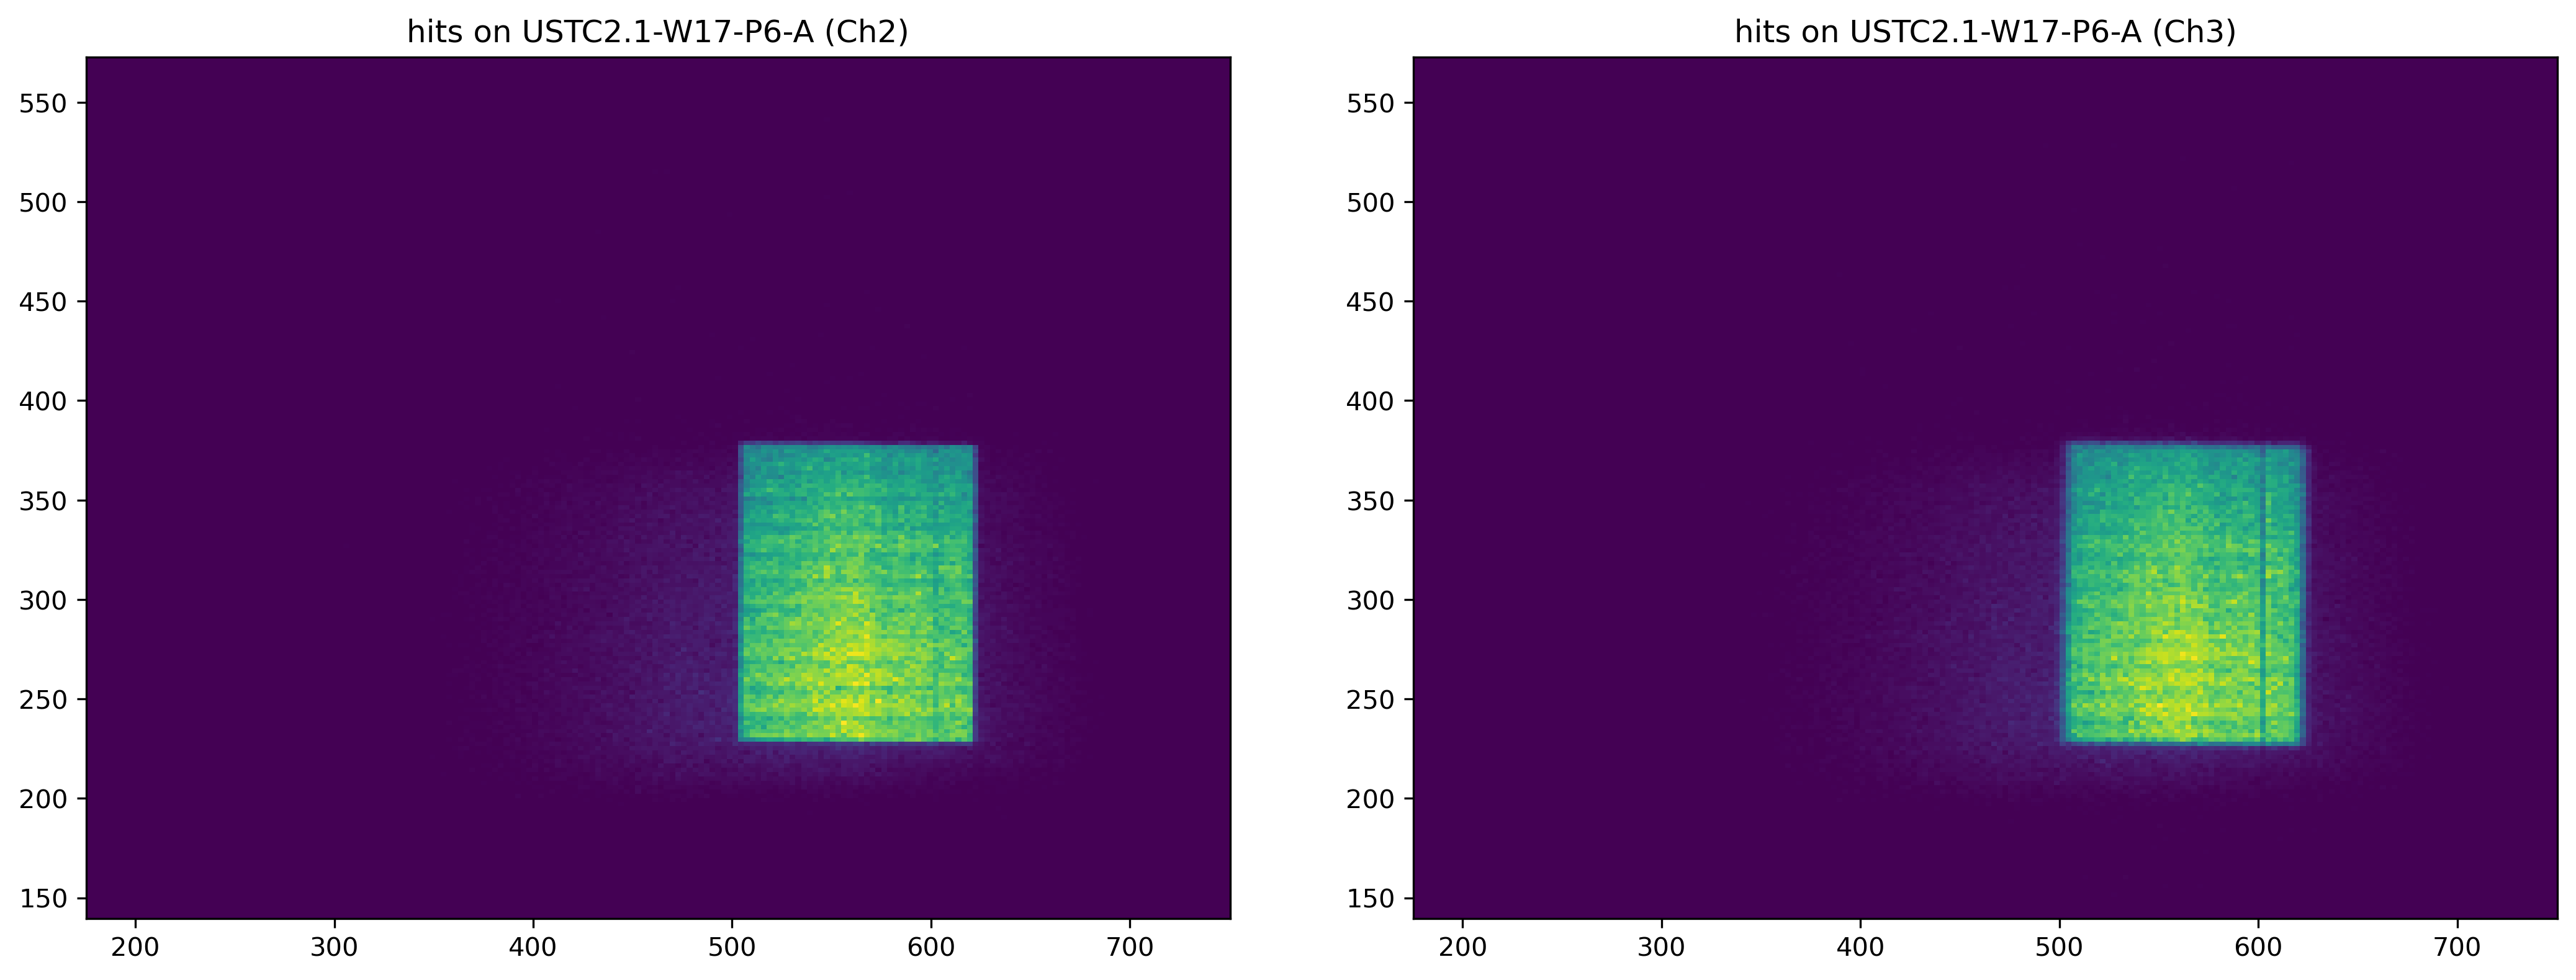

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2 ,figsize=(14,6), dpi=300, sharex='all')
fig.tight_layout(w_pad=4)

Xtr_1 = df[this_scope]["Xtr_1"]#*pixel_size
Ytr_1 = df[this_scope]["Ytr_1"]#*pixel_size
ax[0].hist2d(Xtr_1, Ytr_1, bins=(x_bins, y_bins))
ax[0].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch2']} (Ch2)")
ax[0].set_aspect('equal')

Xtr_2 = df[this_scope]["Xtr_2"]#*pixel_size
Ytr_2 = df[this_scope]["Ytr_2"]#*pixel_size
ax[1].hist2d(Xtr_2, Ytr_2, bins=(x_bins, y_bins))
ax[1].set_title(f"hits on {sensors_list[this_batch][this_scope]['Ch3']} (Ch3)")
ax[1].set_aspect('equal')


## Efficiency Study

In [28]:
# efficiency study
charge_threshold = 2 #fC
transimpedance = 4700 
bins = (x_bins_pixels, y_bins_pixels)

total_events_in_bin, x_edges, y_edges,_ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_1)],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_1)],
                                                     bins=bins)#, range=(x_lim.values(), y_lim.values()))

# Create a boolean mask for events above the threshold
events_above_threshold = df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance > charge_threshold

 # Calculate the number of events above threshold in each bin
events_above_threshold_in_bin, _, _, _ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_1.combine(events_above_threshold, my_and))],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_1.combine(events_above_threshold, my_and))],
                                                    bins=(x_edges, y_edges))
# plt.axis('equal')
plt.close()

# Calculate the efficiency for each bin
efficiency_map = np.divide(events_above_threshold_in_bin, total_events_in_bin,
                           where=total_events_in_bin!=0,
                           out=np.zeros_like(events_above_threshold_in_bin))*100 # in percentage

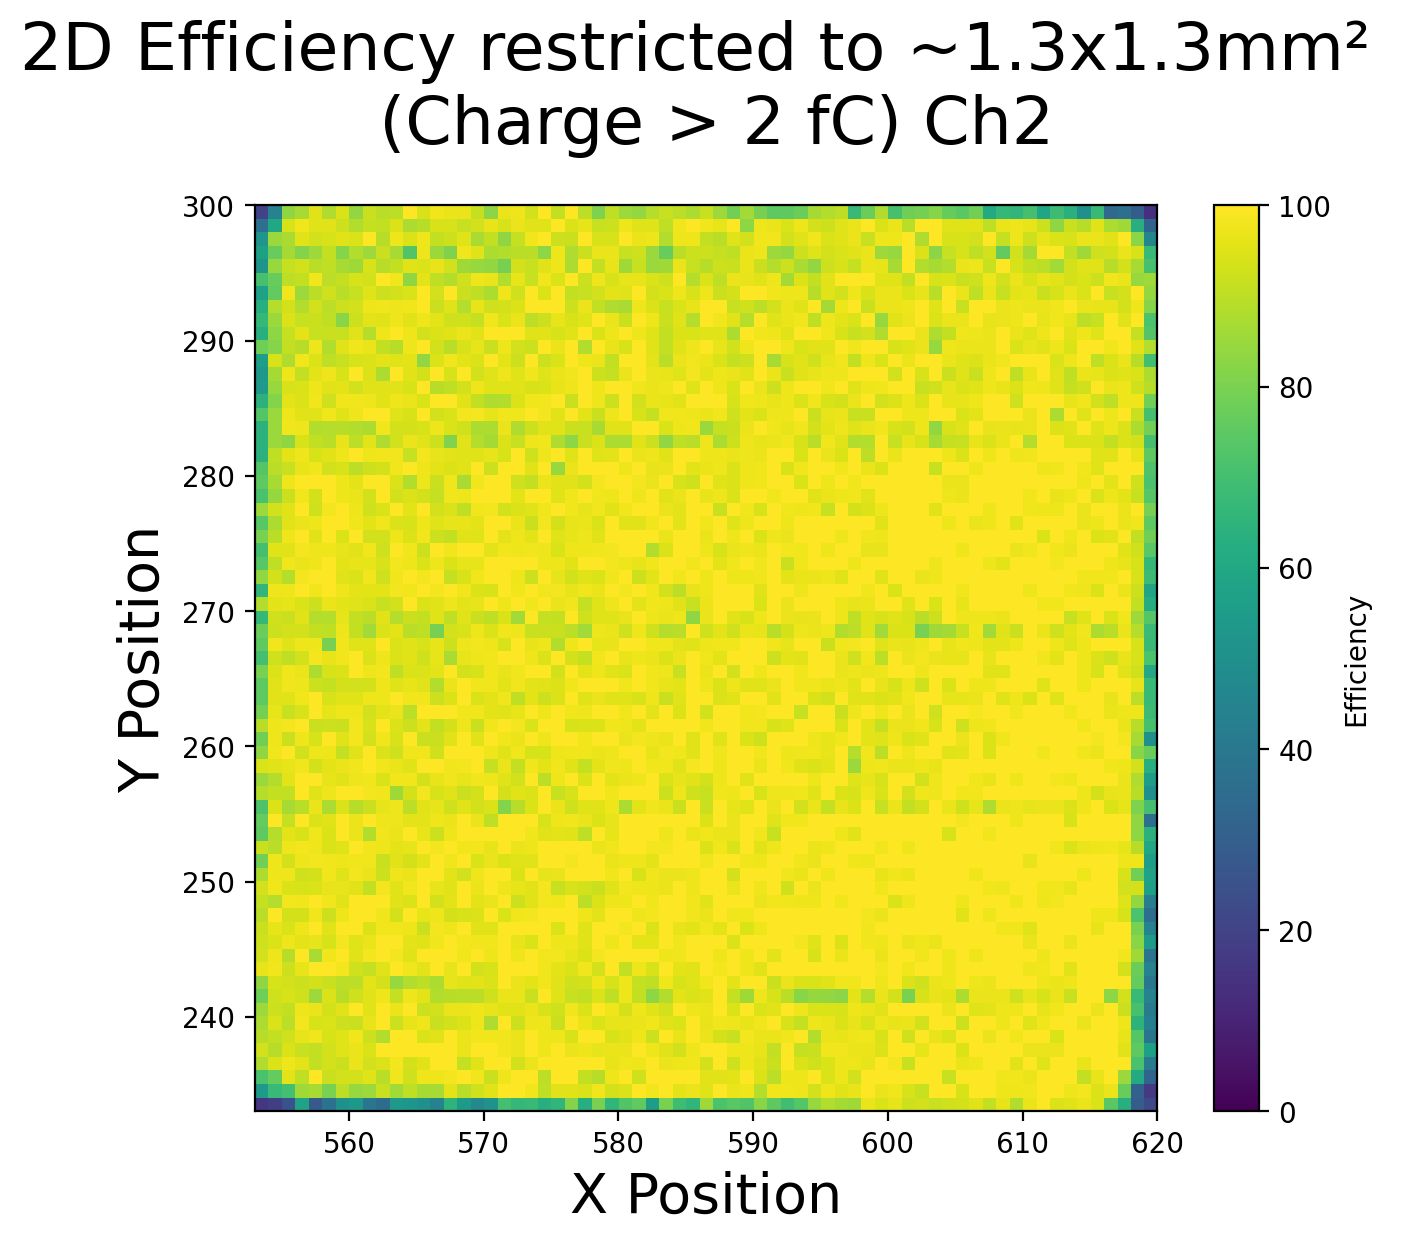

In [29]:
fig = plt.figure(figsize=(7.28, 6), dpi=200)
plt.imshow(efficiency_map.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           aspect='equal', vmin=0, vmax=100)
# fig.tight_layout(pad=7)
plt.colorbar(label='Efficiency')
plt.xlabel('X Position', fontsize=20)
plt.ylabel('Y Position', fontsize=20)
plt.title(f'2D Efficiency restricted to ~1.3x1.3mm² \n (Charge > {charge_threshold} fC) Ch2',
         fontsize=24, y=1.05)
plt.axis('equal')
# plt.xlim(**x_lim)
# plt.ylim(**y_lim)
plt.show()
fig.savefig(f"various plots/Efficiency_heatmap_full_surface_charge_{charge_threshold}fC_{this_batch}.jpg", bbox_inches='tight')

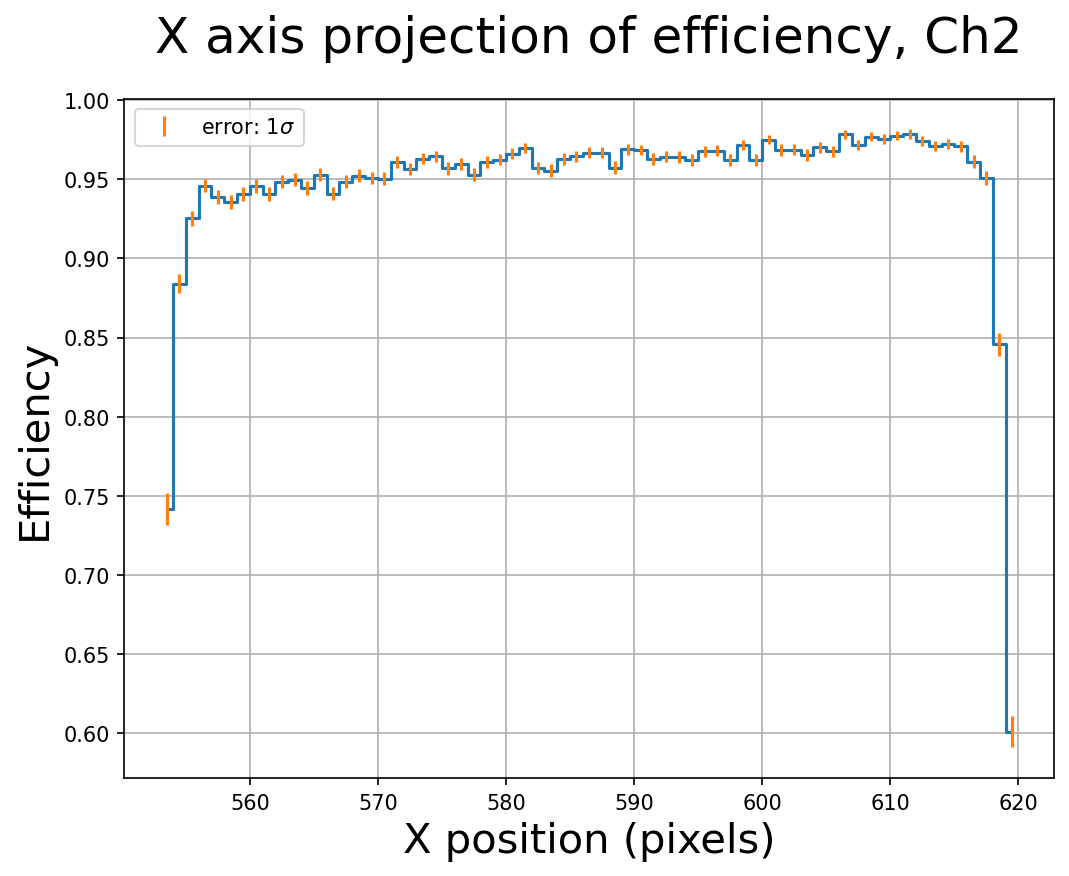

In [30]:
# make a 1d plot (histogram) of the efficiency
# bins = 40
total_events_in_bin1D, bins_edges, _ = plt.hist(df[this_scope]["Xtr_1"].iloc[np.where(geometry_1)],
                                                     bins=x_bins_pixels, histtype='step')

# Create a boolean mask for events above the threshold
events_above_threshold1D = df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance > charge_threshold

# Calculate the number of events above threshold in each bin
events_above_threshold_in_bin1D, _, _ = plt.hist(df["S1"]["Xtr_1"].iloc[np.where(
                                            geometry_1.combine(events_above_threshold1D, my_and))],
                                            bins=x_bins_pixels, histtype='step')
plt.close()

fig, ax = plt.subplots(figsize=(8,6), dpi=150)
bins_centers = (bins_edges[:-1]+bins_edges[1:])/2

eff, err = efficiency_k_n(events_above_threshold_in_bin1D, total_events_in_bin1D)
ax.step(bins_centers, eff, where='mid')
sigma_coeff = 1
ax.errorbar(bins_centers, eff, yerr=sigma_coeff*err, elinewidth=1.5, markersize=0, linewidth=0,
            label=f"error: {sigma_coeff}$\sigma$")

ax.set_title(f"X axis projection of efficiency, Ch2", fontsize=24, y=1.05)
ax.set_xlabel("X position (pixels)", fontsize=20)
ax.set_ylabel("Efficiency", fontsize=20)
ax.grid('--')
ax.legend()
# fig.savefig(f"various plots/X_axis_projection_efficiency_USTC_{this_batch}.jpg")

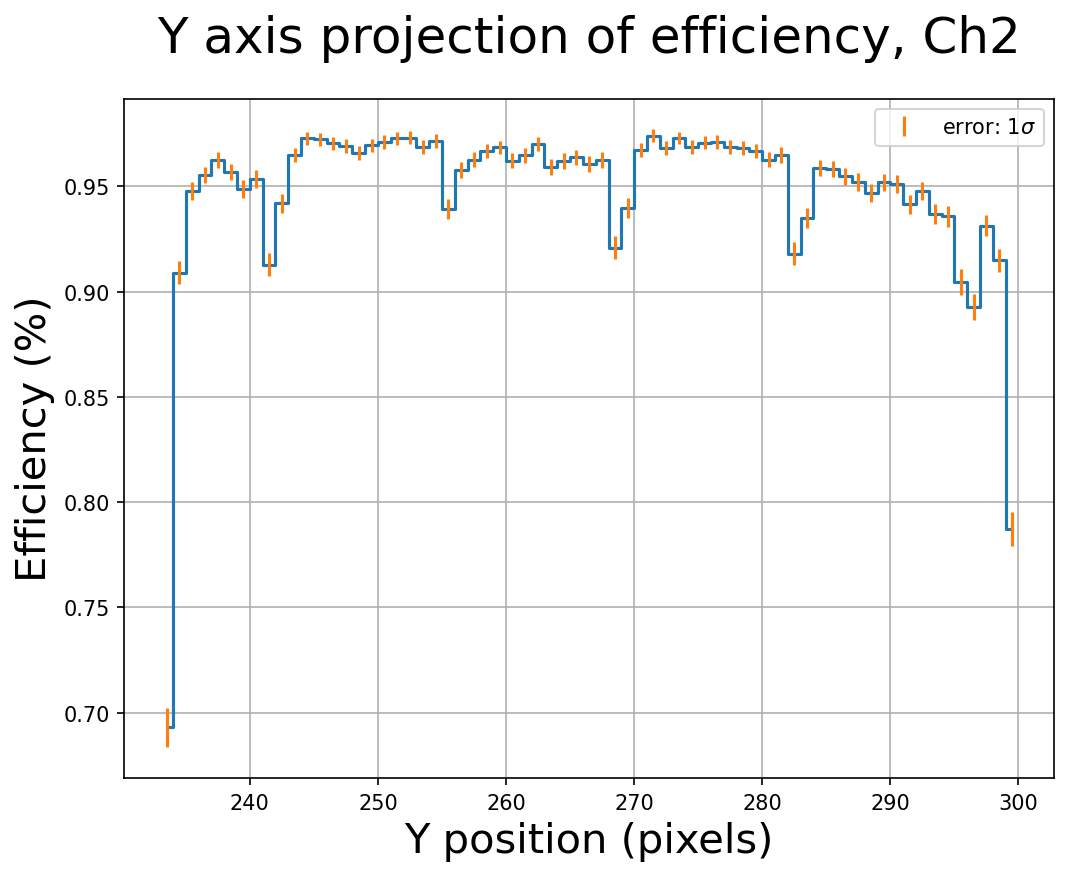

In [31]:
# make a 1d plot (histogram) of the efficiency
# bins = 40
total_events_in_bin1D, bins_edges, _ = plt.hist(df[this_scope]["Ytr_1"].iloc[np.where(geometry_1)],
                                                     bins=y_bins_pixels, histtype='step')

# Create a boolean mask for events above the threshold
events_above_threshold1D = df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance > charge_threshold

# Calculate the number of events above threshold in each bin
events_above_threshold_in_bin1D, _, _ = plt.hist(df["S1"]["Ytr_1"].iloc[np.where(
                                            geometry_1.combine(events_above_threshold1D, my_and))],
                                            bins=y_bins_pixels, histtype='step')
plt.close()

fig, ax = plt.subplots(figsize=(8,6), dpi=150)
bins_centers = (bins_edges[:-1]+bins_edges[1:])/2

eff, err = efficiency_k_n(events_above_threshold_in_bin1D, total_events_in_bin1D)
ax.step(bins_centers, eff, where='mid')
sigma_coeff = 1
ax.errorbar(bins_centers, eff, yerr=sigma_coeff*err, elinewidth=1.5, markersize=0, linewidth=0,
            label=f"error: {sigma_coeff}$\sigma$")

ax.set_title(f"Y axis projection of efficiency, Ch2", fontsize=24, y=1.05)
ax.set_xlabel("Y position (pixels)", fontsize=20)
ax.set_ylabel("Efficiency (%)", fontsize=20)
ax.grid('--')
ax.legend() 
# fig.savefig(f"various plots/Y_axis_projection_efficiency_USTC_{this_batch}.jpg")

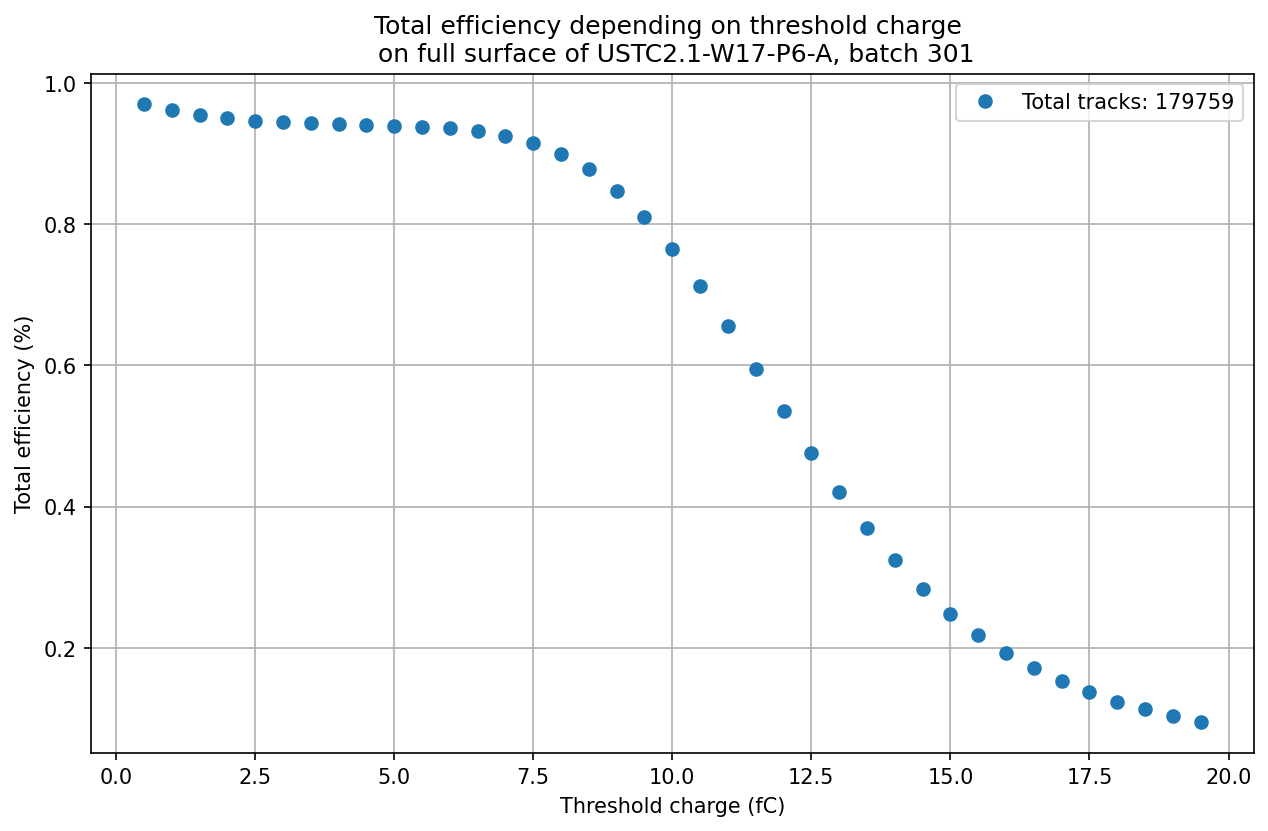

In [32]:
# total efficiency
transimpedance = 4700 # 10700
efficiency_range = []
threshold_range = np.arange(0.5, 20, 0.5)

for charge in threshold_range:
    efficiency_range.append(efficiency(
        df[this_scope]["charge_1"].iloc[np.where(geometry_1)]/transimpedance, charge, percentage=False))

fig, ax = plt.subplots(figsize=(10,6), dpi=150)
ax.plot(threshold_range, efficiency_range,'o', 
        label=f"Total tracks: {df[this_scope]['charge_1'].iloc[np.where(geometry_1)].size}")
ax.set_title(f"Total efficiency depending on threshold charge \n \
on full surface of {these_sensors[1]}, batch {this_batch}")
ax.set_xlabel("Threshold charge (fC)")
ax.set_ylabel("Total efficiency (%)")
ax.grid('--')
ax.legend()
# fig.savefig(f"various plots/Total_efficiency_change_USTC_{this_batch}.jpg")

## Efficiency in the central part 
Calculate the efficiency in the central $0.5x0.5$ $mm^2$

In [33]:
edges_central = copy.deepcopy(edges) # make a copy of edges{}
new_width = 0.5 # mm
new_width_pixel = np.ceil(new_width/pixel_size) # 500um = 0.5mm

for ch, values in edges.items():
    # define the new edges as 1/2 the new edge size to the left and right (bottom and top) from the center
    central_pos = (edges[ch]["left"] + edges[ch]["right"])/2  # center
    edges_central[ch]["left"] = central_pos - new_width_pixel/2    # center - width/2
    edges_central[ch]["right"] = central_pos + new_width_pixel/2   # center + width/2
    
    central_pos = (edges[ch]["bottom"]+edges[ch]["top"])/2
    edges_central[ch]["bottom"] = central_pos - new_width_pixel/2
    edges_central[ch]["top"] = central_pos + new_width_pixel/2

xgeometry_1 = (df[this_scope]["Xtr_1"]>edges_central["Ch2"]["left"]).combine((
                df[this_scope]["Xtr_1"]<edges_central["Ch2"]["right"]), my_and)
ygeometry_1 = (df[this_scope]["Ytr_1"]>edges_central["Ch2"]["bottom"]).combine((
                df[this_scope]["Ytr_1"]<edges_central["Ch2"]["top"]), my_and) 
geometry_small_1 = xgeometry_1.combine(ygeometry_1, my_and)

xgeometry_2 = (df[this_scope]["Xtr_2"]>edges_central["Ch3"]["left"]).combine((
                df[this_scope]["Xtr_2"]<edges_central["Ch3"]["right"]), my_and)
ygeometry_2 = (df[this_scope]["Ytr_2"]>edges_central["Ch3"]["bottom"]).combine((
                df[this_scope]["Ytr_2"]<edges_central["Ch3"]["top"]), my_and) 
geometry_small_2 = xgeometry_2.combine(ygeometry_2, my_and)

In [34]:
print(edges["Ch2"])
print(edges_central["Ch2"])

{'left': 553.314325755407, 'right': 620.0606368009956, 'bottom': 233.12319022860817, 'top': 299.96337069760455}
{'left': 572.6874812782013, 'right': 600.6874812782013, 'bottom': 252.54328046310638, 'top': 280.5432804631064}


In [35]:
# efficiency study
charge_threshold = 2 #fC
transimpedance = 4700 
bins = (int(new_width_pixel), int(new_width_pixel))

total_events_in_bin, x_edges_small, y_edges_small,_ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_small_1)],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_small_1)],
                                                     bins=bins)#, range=(x_lim.values(), y_lim.values()))

# Create a boolean mask for events above the threshold
events_above_threshold = df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance > charge_threshold

 # Calculate the number of events above threshold in each bin
events_above_threshold_in_bin, _, _, _ = plt.hist2d(df[this_scope]["Xtr_1"].iloc[np.where(geometry_small_1.combine(events_above_threshold, my_and))],
                                                    df[this_scope]["Ytr_1"].iloc[np.where(geometry_small_1.combine(events_above_threshold, my_and))],
                                                    bins=(x_edges_small, y_edges_small))
# plt.set_aspect('equal')
plt.close()

# Calculate the efficiency for each bin
efficiency_map_small = np.divide(events_above_threshold_in_bin, total_events_in_bin,
                           where=total_events_in_bin!=0,
                           out=np.zeros_like(events_above_threshold_in_bin))*100 # in percentage

In [36]:
# edges_central["Ch2"]["left"]

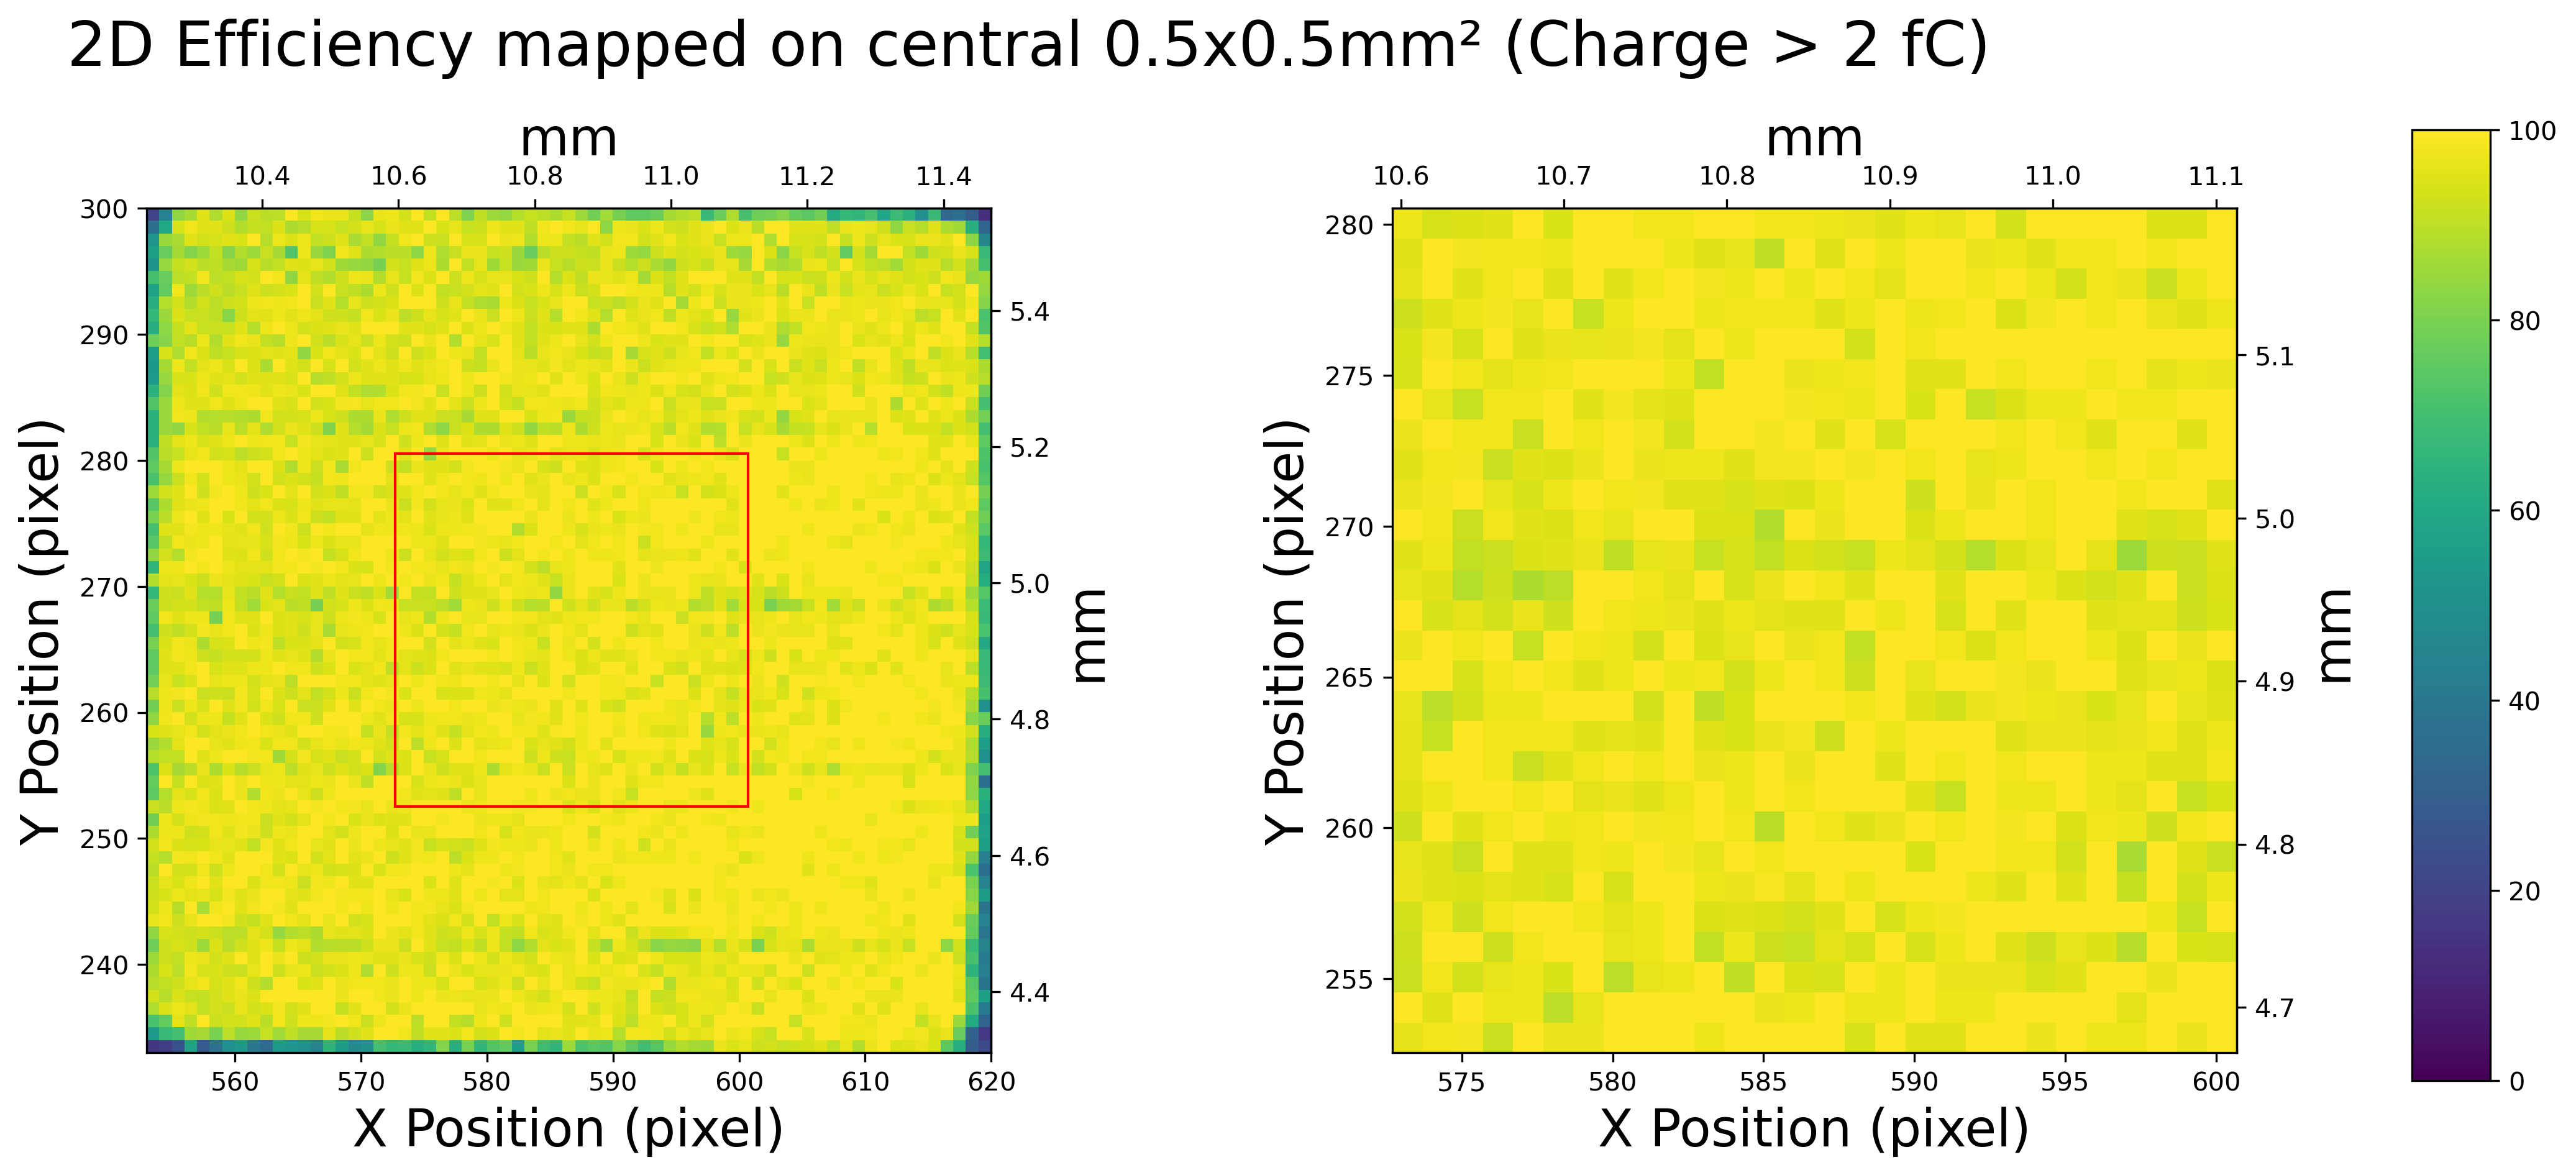

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2 ,figsize=(14,6), dpi=300)#, gridspec_kw={'width_ratios':[5,5,1]})

im = axes[0].imshow(efficiency_map.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           aspect='equal', vmin=0, vmax=100)

rect = mpatches.Rectangle((edges_central["Ch2"]["left"], edges_central["Ch2"]["bottom"]), new_width_pixel, new_width_pixel,
                          linewidth=1, edgecolor='r', facecolor='none') # small 
axes[0].add_patch(rect)
# ax[0].colorbar(label='Efficiency')
axes[0].set_xlabel('X Position (pixel)', fontsize=20)
axes[0].set_ylabel('Y Position (pixel)', fontsize=20)
secx = axes[0].secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secy = axes[0].secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secx.set_xlabel('mm', fontsize=20)
secy.set_ylabel('mm', fontsize=20)

axes[1].imshow(efficiency_map_small.T, origin='lower', extent=[x_edges_small[0], x_edges_small[-1], y_edges_small[0], y_edges_small[-1]],
           aspect='equal', vmin=0, vmax=100)
axes[1].set_xlabel('X Position (pixel)', fontsize=20)
axes[1].set_ylabel('Y Position (pixel)', fontsize=20)
secx = axes[1].secondary_xaxis('top', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secy = axes[1].secondary_yaxis('right', functions=(lambda x: x*pixel_size, lambda x: x*pixel_size))
secx.set_xlabel('mm', fontsize=20)
secy.set_ylabel('mm', fontsize=20)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

# plt.colorbar(im, cax=axes[2], fraction=1)
fig.subplots_adjust(right=1)
# plt.colorbar(im, label="Efficiency")

cbar_ax = fig.add_axes([1.03, 0.1, 0.03, 0.85])
fig.colorbar(im, cax=cbar_ax, aspect=2)

fig.suptitle(f'2D Efficiency mapped on central 0.5x0.5mm² (Charge > {charge_threshold} fC)', fontsize=24, y=1.05)
# plt.xlim(**x_lim)
# plt.ylim(**y_lim)
# plt.show()
fig.savefig(f"various plots/Efficiency_central_area_zoomed_heatmap_charge_{charge_threshold}fC_{this_batch}.jpg", bbox_inches='tight')

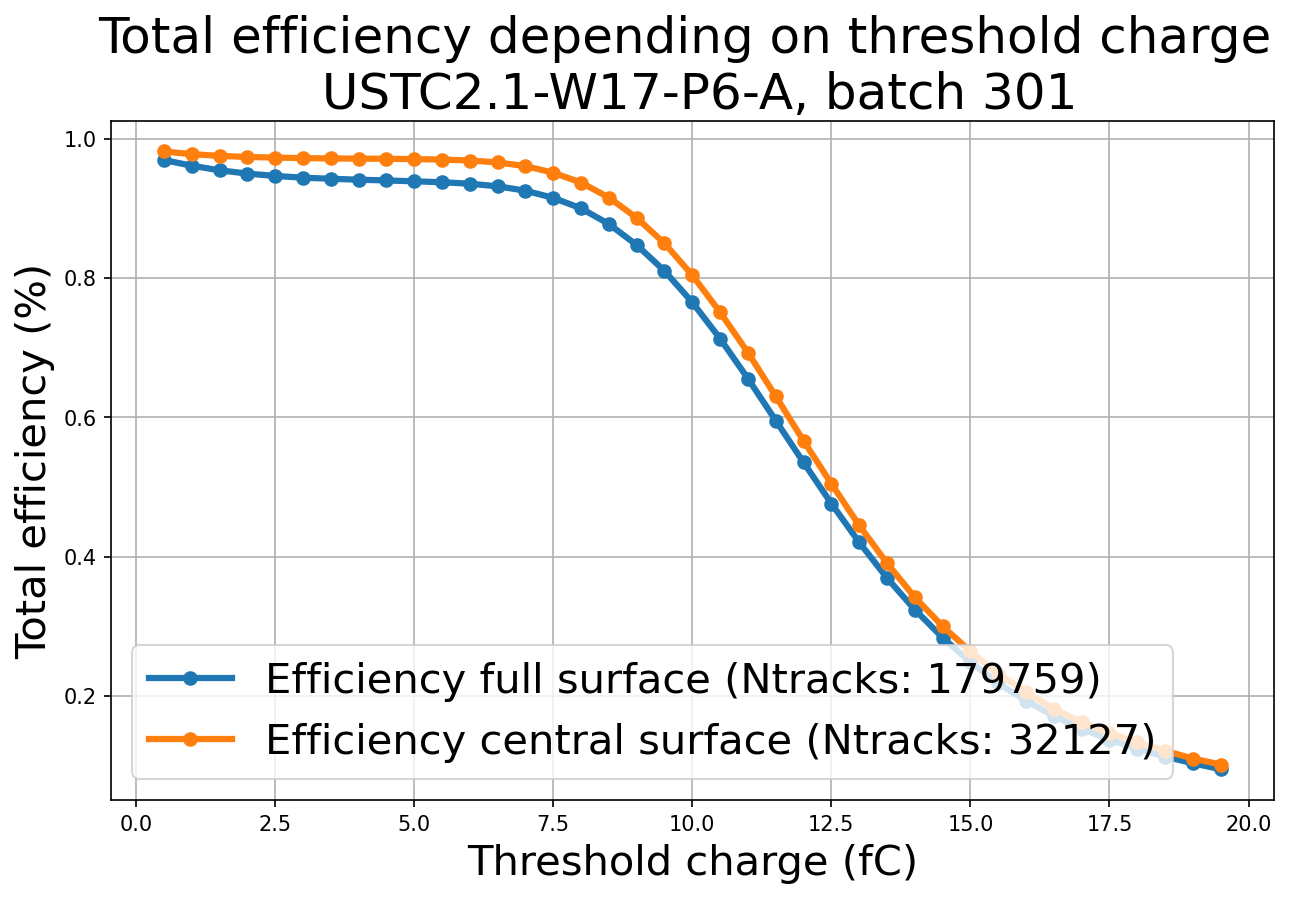

In [38]:
# total efficiency
transimpedance = 4700 # 10700
efficiency_range_small = []
error_range_small = []
threshold_range = np.arange(0.5, 20, 0.5)

for charge in threshold_range:
    eff, err = efficiency_error(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance, charge)
    efficiency_range_small.append(eff)
    error_range_small.append(err)

fig, ax = plt.subplots(figsize=(10,6), dpi=150)
ax.plot(threshold_range, efficiency_range, label=f"Efficiency full surface (Ntracks: {df[this_scope]['charge_1'].iloc[np.where(geometry_1)].size})",
        linewidth=3, marker='o')
ax.plot(threshold_range, efficiency_range_small, label=f"Efficiency central surface (Ntracks: {df[this_scope]['charge_1'].iloc[np.where(geometry_small_1)].size})",
        linewidth=3, marker='o')
# ax.errorbar(threshold_range, efficiency_range_small, label="Efficiency central surface + Poissonian err ($3\sigma$)",
#             yerr=3*err, linewidth=1, elinewidth=2, ecolor='k')
ax.set_title(f"Total efficiency depending on threshold charge \n {these_sensors[1]}, batch {this_batch}", fontsize=24)
ax.set_xlabel("Threshold charge (fC)", fontsize=20)
ax.set_ylabel("Total efficiency (%)", fontsize=20)
# ax.set_ylim(90,100)
ax.grid('--')
ax.legend(fontsize=20, loc='lower left')
fig.savefig(f"various plots/Total_efficiency_smallarea_change_USTC_{this_batch}.jpg")

In [39]:
efficiency_error(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance, 2)
print(sum(df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]/transimpedance>2))
# print((df[this_scope]["charge_1"].iloc[np.where(geometry_small_1)]).size)

31280


## Now I really should look at how to match with the time
(in the other file?)

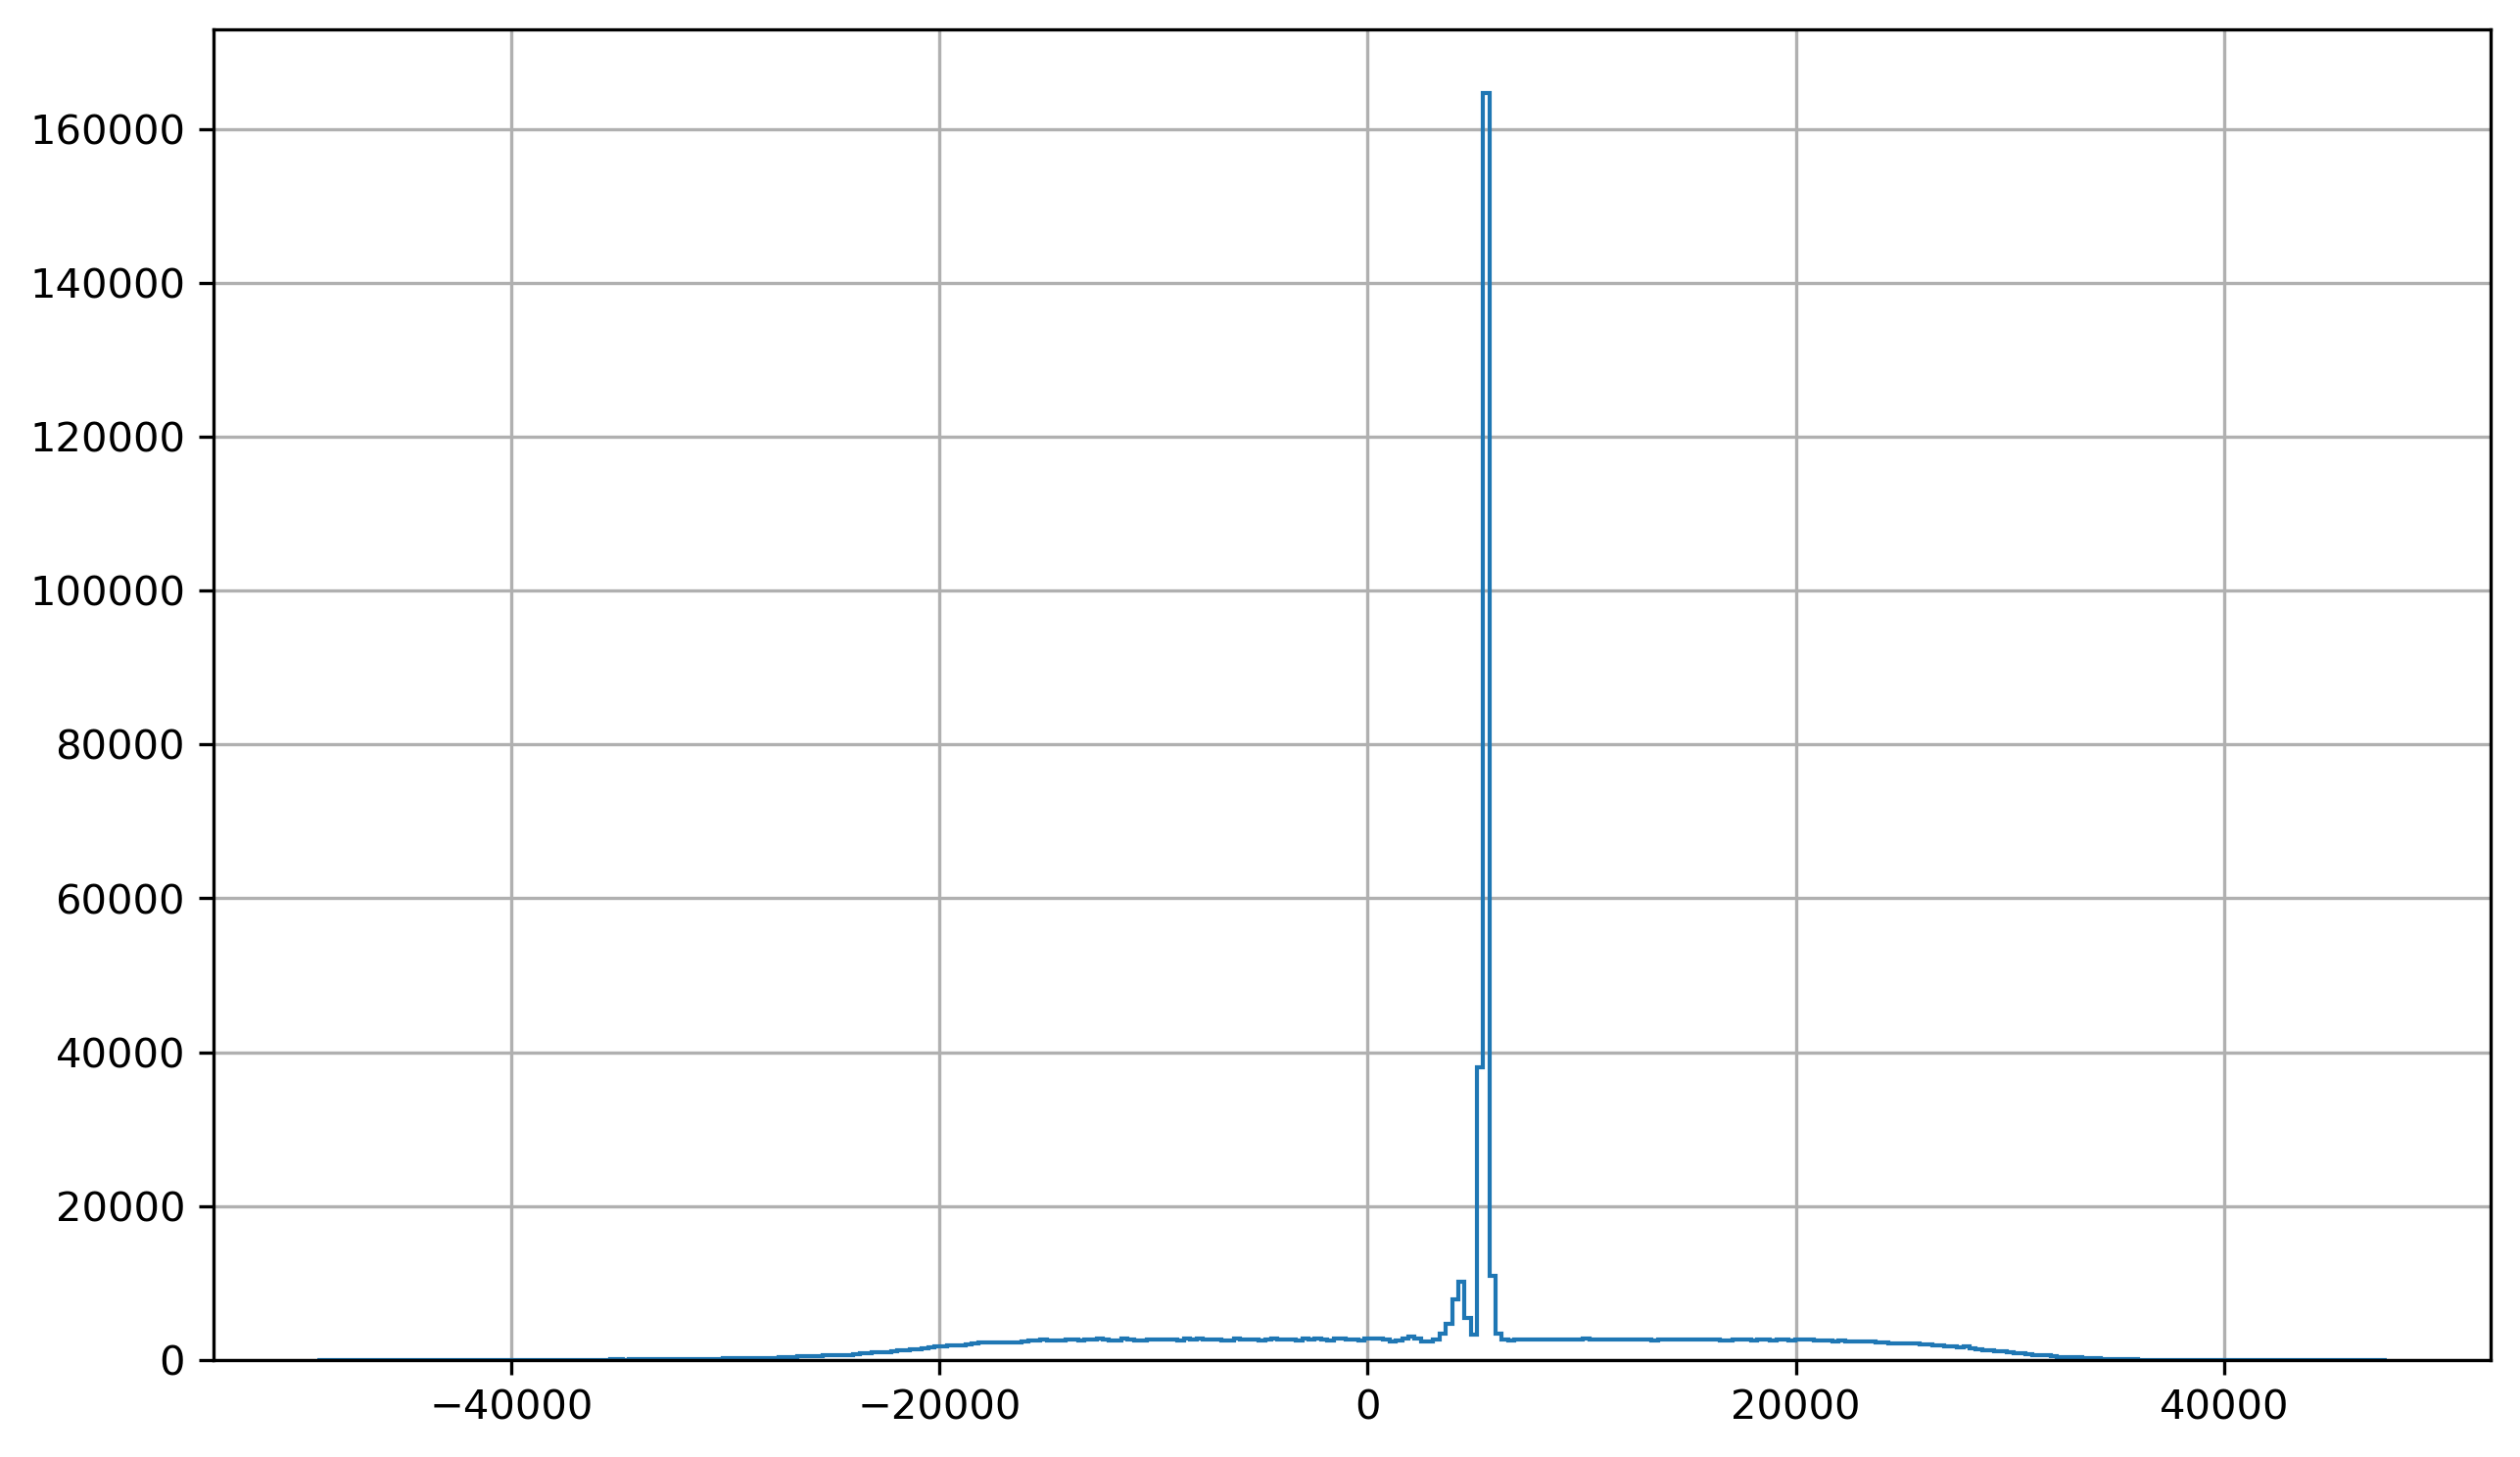

In [94]:
fig, ax = plot_histogram(df[this_scope]["timeCFD20_0"]-df[this_scope]["timeCFD50_1"])#-df[this_scope]["timeCFD50_1"])
# add_histogram(ax,df[this_scope]["timeCFD50_1"])
# plt.axvline(5500)

In [89]:
dict_mins

{301: {'S1': {'pulseHeight_1': 20.95148, 'pulseHeight_2': 22.097279}}}

/tmp/ipykernel_25204/2225873244.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")


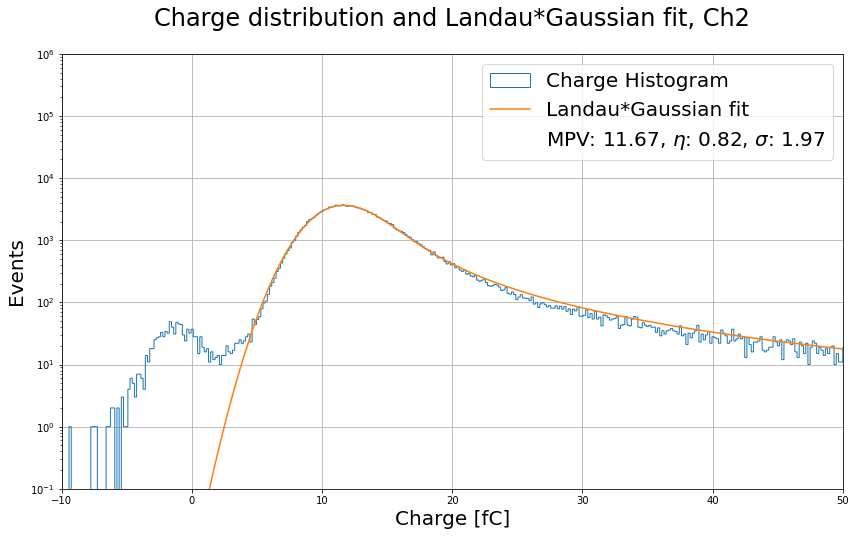

In [54]:
fig, ax = plt.subplots(figsize=(14,8))
# ax.axvline(x=charge_threshold, color='r', label=f'threshold charge: {charge_threshold}fC')
charge_hist, bins_hist, _ = ax.hist(df[this_scope]["charge_1"].iloc[np.where(
    geometry_1.combine(filter_1, my_and))]/transimpedance,
                                    bins='auto', histtype='step', label='Charge Histogram')
bins_centers = (bins_hist[1:]+bins_hist[:-1])/2
bins_centers = bins_centers.astype(np.float64)

param, covariance = curve_fit(pylandau.langau, bins_centers, charge_hist, p0=(10,1,1,4000))
# print(param)
ax.plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
ax.semilogy()
ax.set_xlim(-10, 50)
ax.set_ylim(0.1,1e6)
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.set_title(f"Charge distribution and Landau*Gaussian fit, Ch2", fontsize=24, y=1.05)
ax.grid('--')
legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color='none', label=legend_text))
ax.legend(handles=handles, fontsize=20);
fig.savefig(f"various plots/Charge_distribution_fit_Ch2_{this_batch}.jpg")

In [438]:
covariance[0,0]**(1/2)

0.0036230396137001512

In [ ]:
# fig, ax = plot_histogram(df[this_scope]["charge_1"].iloc[np.where(df[this_scope]["pulseHeight_1"]>21.3)]/transimpedance)
# ax.plot(bins_centers, pylandau.langau(bins_centers, *param))
# ax.set_xlim(-10, 100)
# legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])
# handles, labels = ax.get_legend_handles_labels()
# handles.append(mpatches.Patch(color='none', label=legend_text))
# ax.axvline(x=4, color='r')
# ax.legend(fontsize=14)
# ax.legend(handles=handles, fontsize=14);
# ax.set_xlabel("Charge [fC]")
# ax.set_title("Batch 301, USTC2.1-W17-P6-A")

In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))
# for i in range(1000,3000,200):

#     bins = i
#     print(find_min_btw_peaks(df[Scope]["pulseHeight_3"], bins=i, prominence=None, distance=10, plot=True))
# ax.set_xlim(-5,20)